In [1]:
import glob


In [3]:
glob.glob('./s0_data/**')

['./s0_data/11,2,2000,ram',
 './s0_data/17,2,3216,ram',
 './s0_data/2,3,400,ram',
 './s0_data/13,2,2412,ram',
 './s0_data/2,2,400,ram',
 './s0_data/7,2,1200,ram',
 './s0_data/5,3,12524,unram',
 './s0_data/2,3,1400,unram',
 './s0_data/7,3,10602,unram',
 './s0_data/5,2,804,ram',
 './s0_data/3,2,800,ram',
 './s0_data/3,3,5200,unram']

11-adic Eisenstein Extension Field in y defined by x^2 - 11
17-adic Eisenstein Extension Field in y defined by x^2 - 17
2-adic Eisenstein Extension Field in y defined by x^3 - 2
13-adic Eisenstein Extension Field in y defined by x^2 - 13
2-adic Eisenstein Extension Field in y defined by x^2 - 2
7-adic Eisenstein Extension Field in y defined by x^2 - 7
5-adic Unramified Extension Field in y defined by x^3 + x + 1
2-adic Unramified Extension Field in y defined by x^3 + x + 1
7-adic Unramified Extension Field in y defined by x^3 + 2
5-adic Eisenstein Extension Field in y defined by x^2 - 5
3-adic Eisenstein Extension Field in y defined by x^2 - 3
3-adic Unramified Extension Field in y defined by x^3 + 2*x + 1


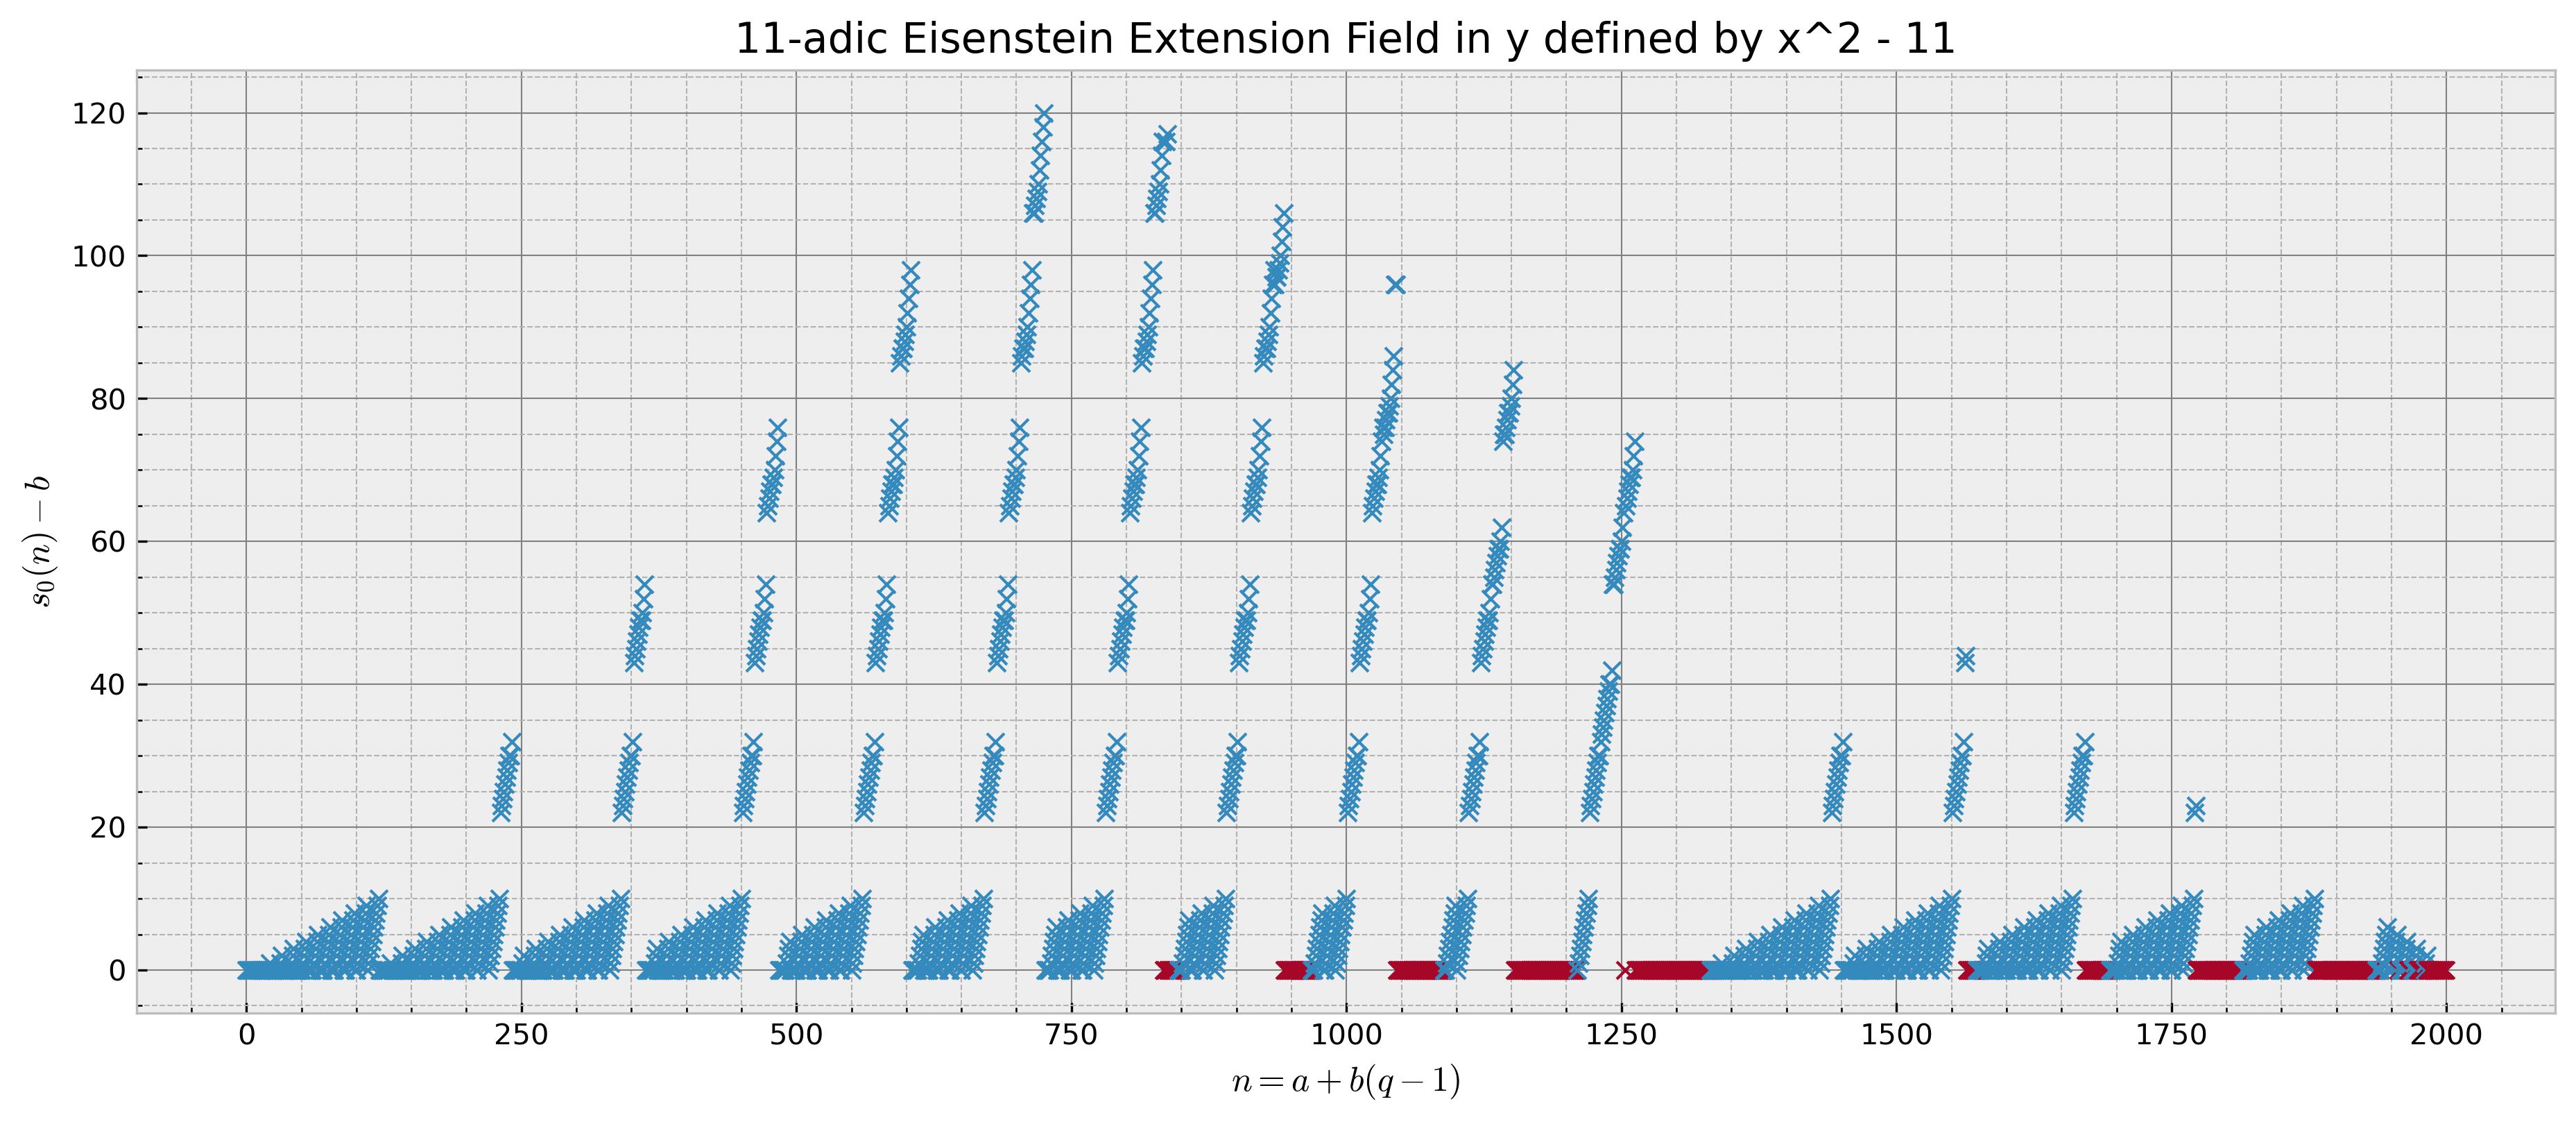

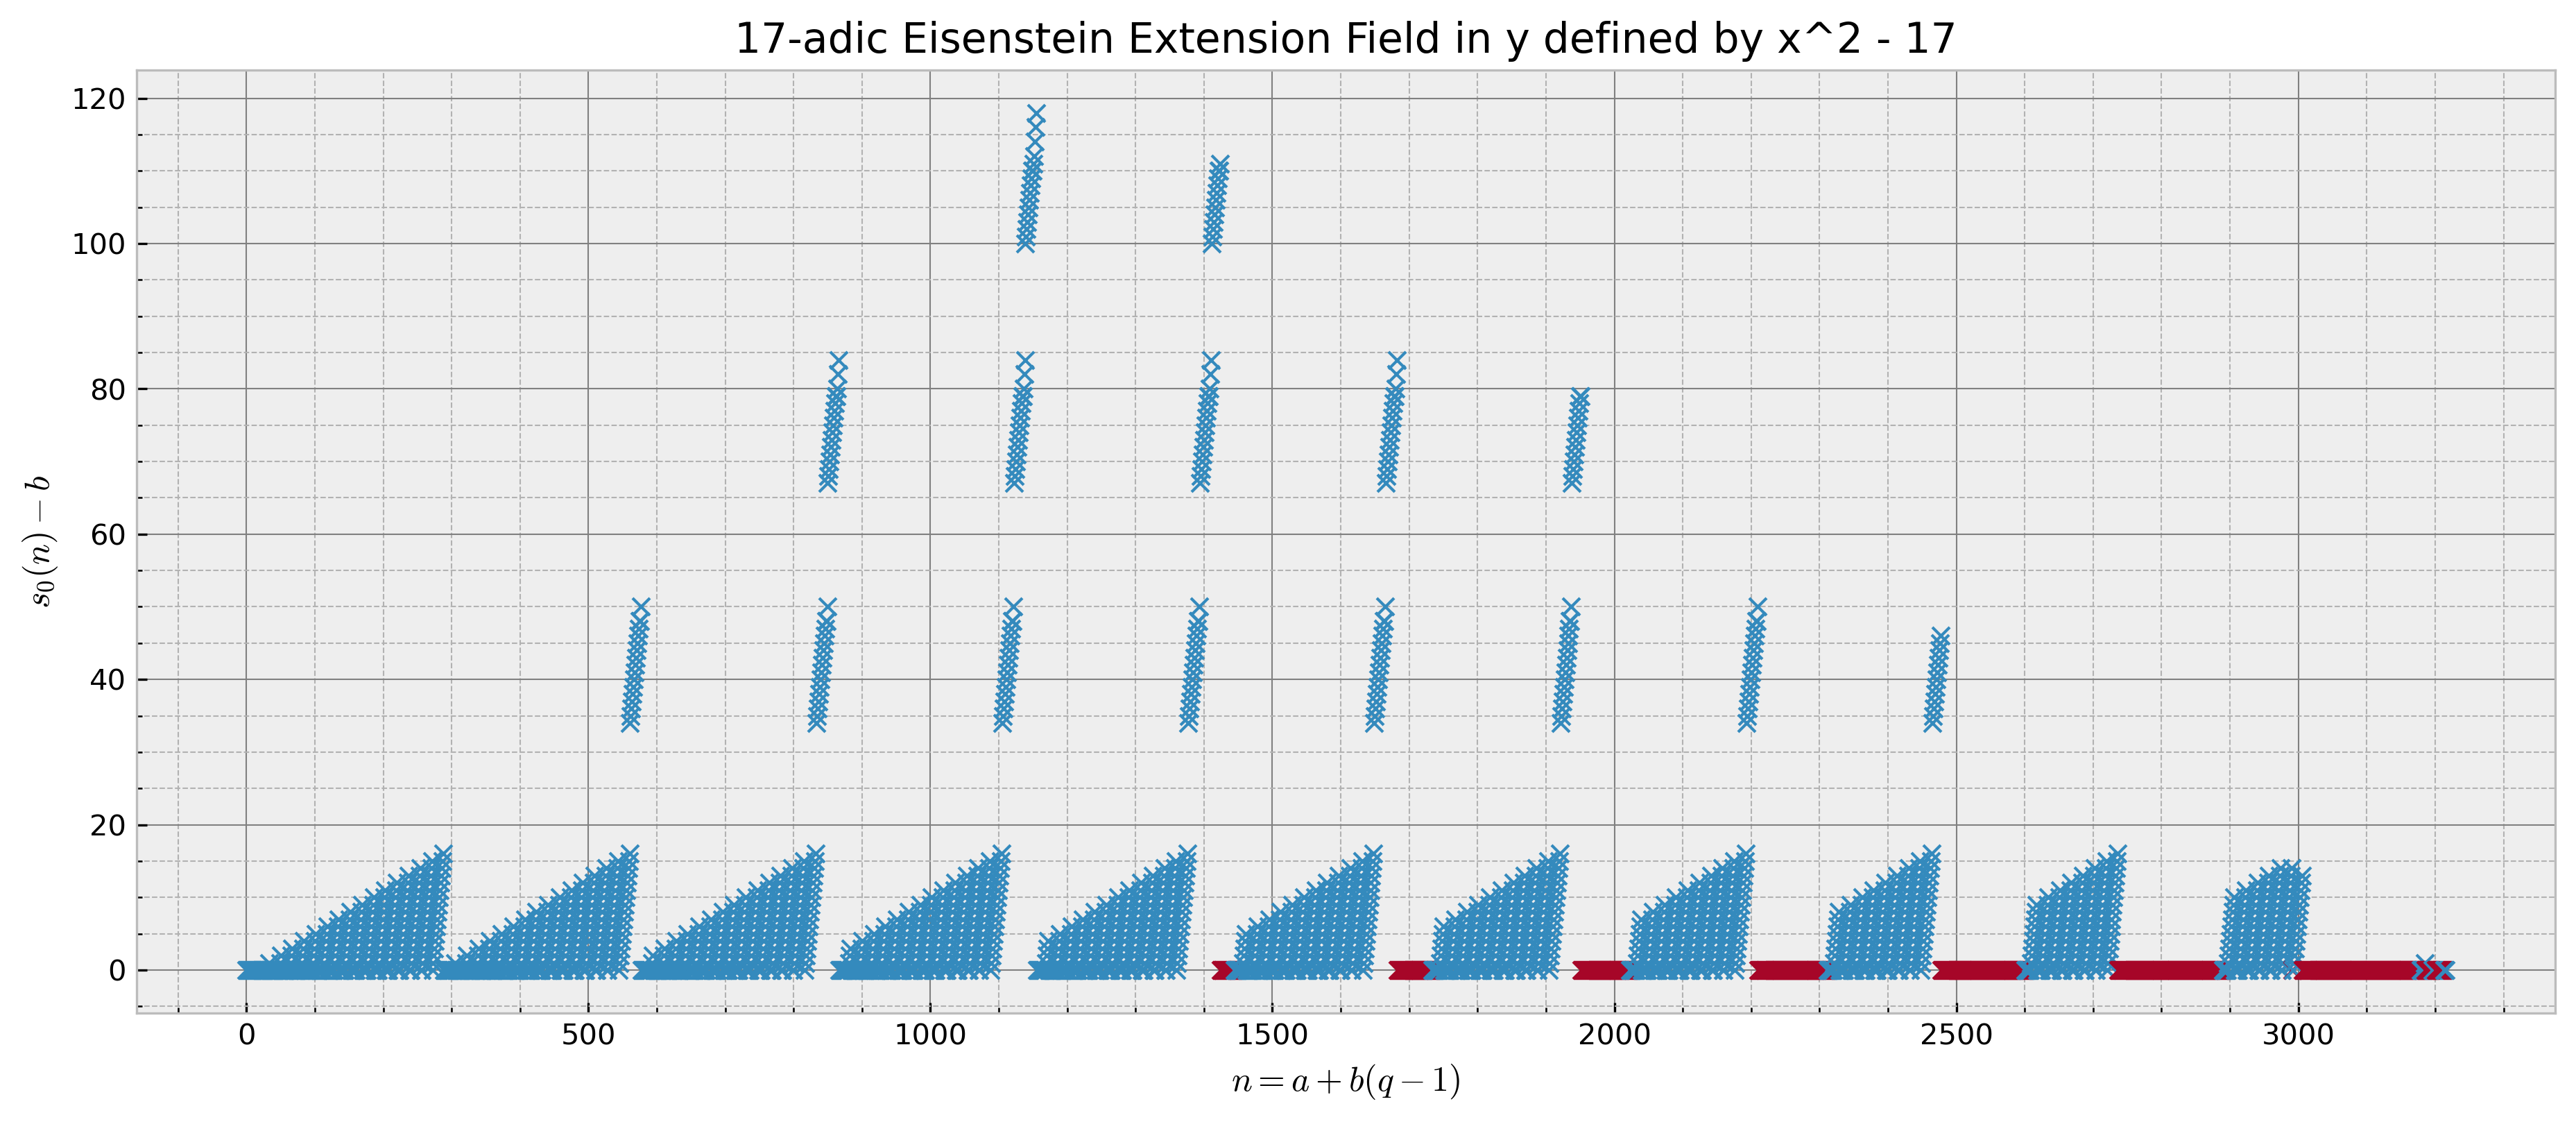

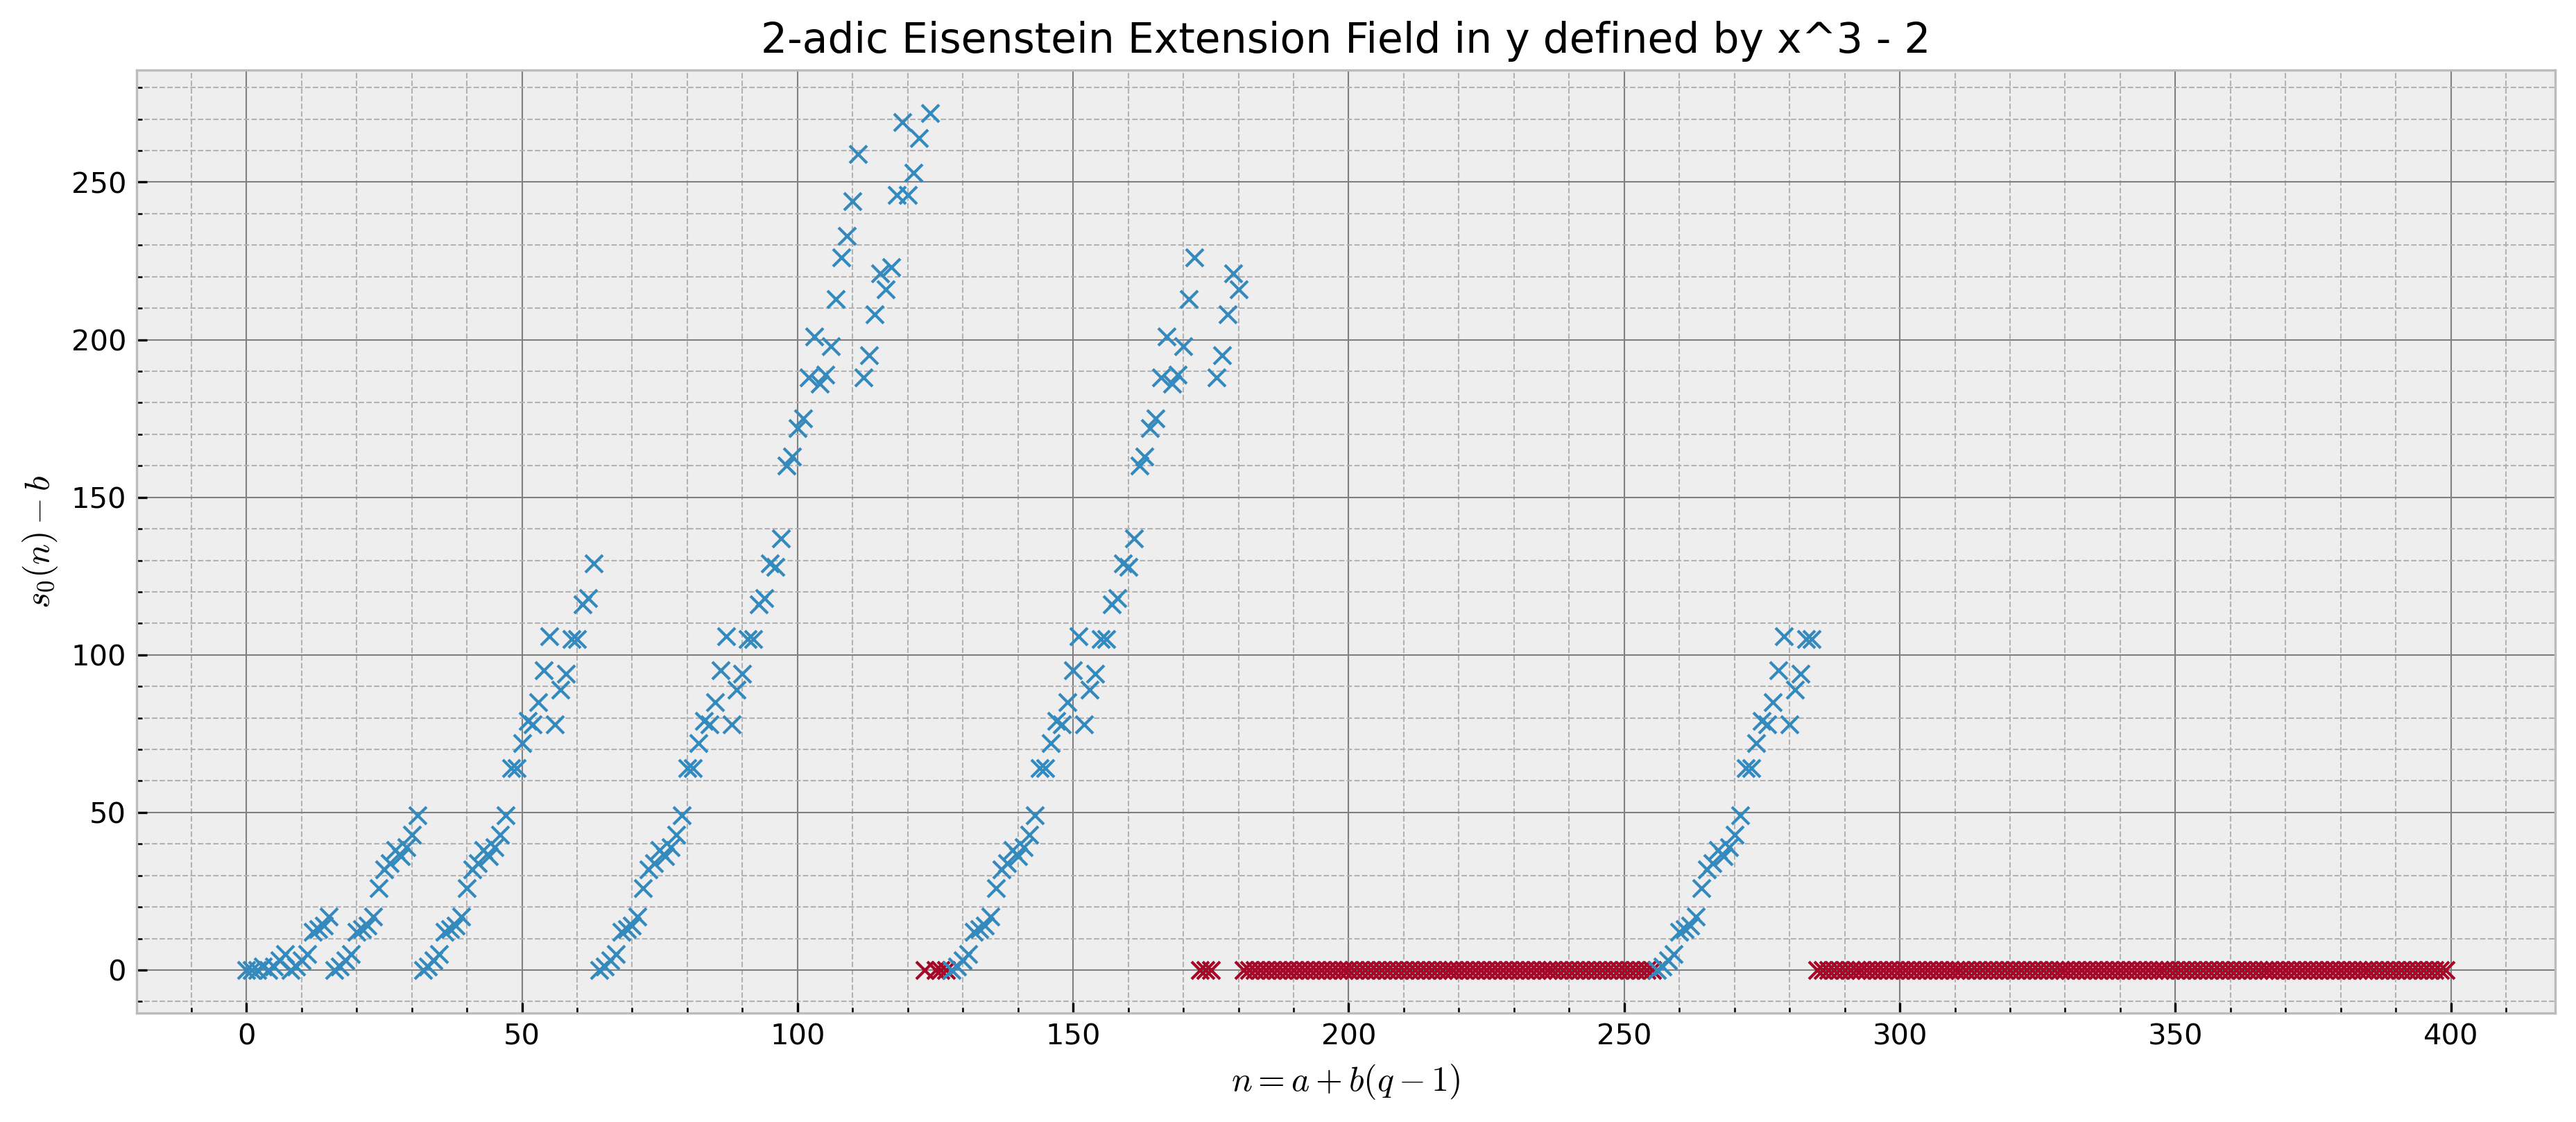

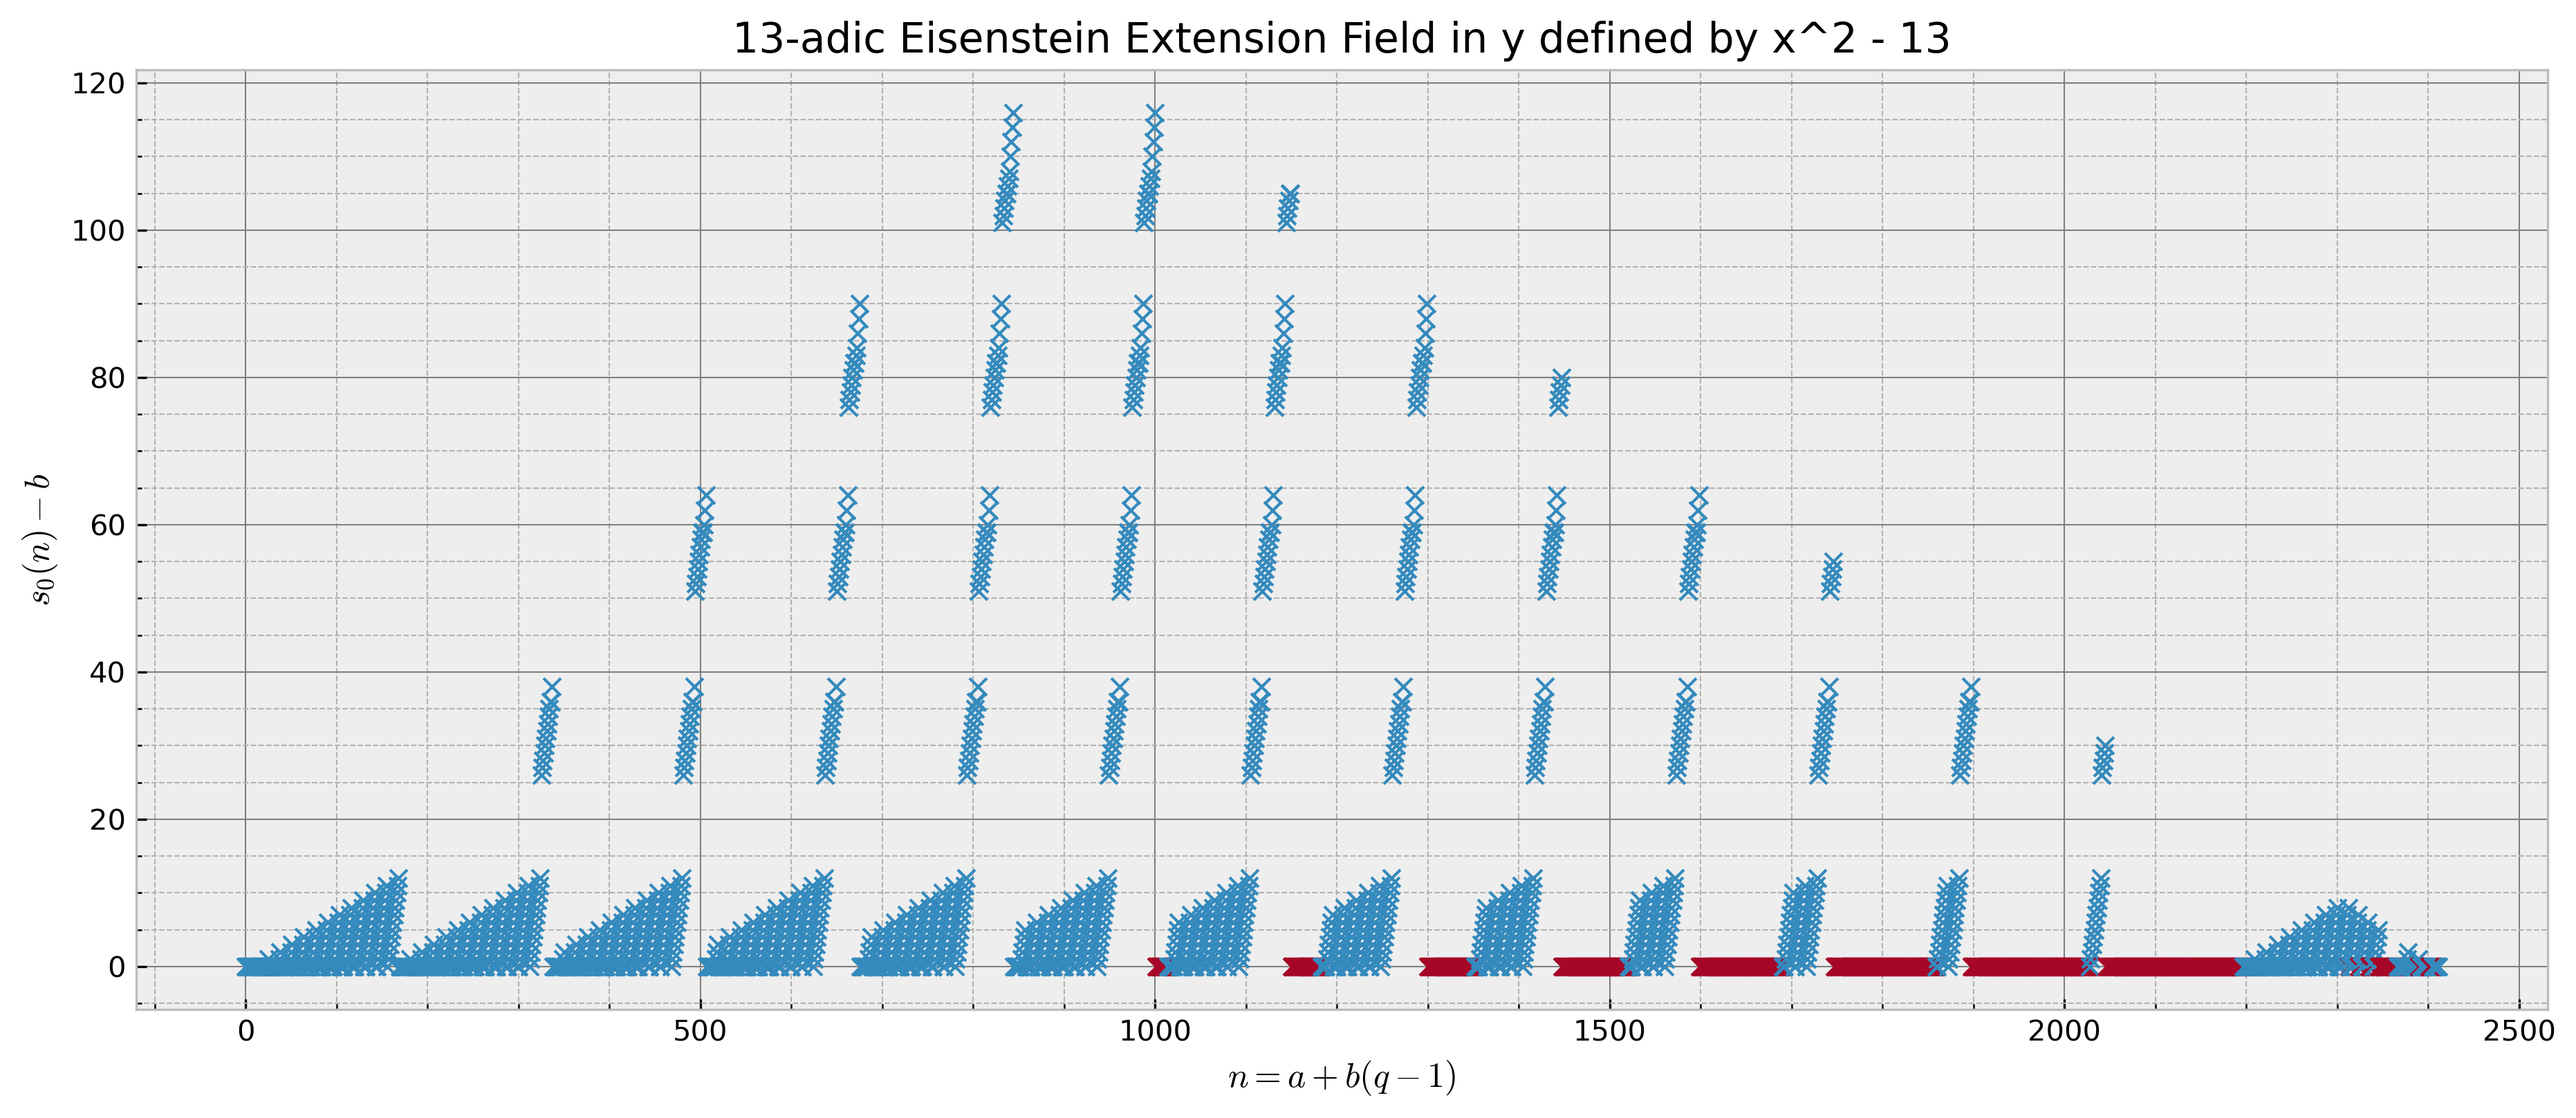

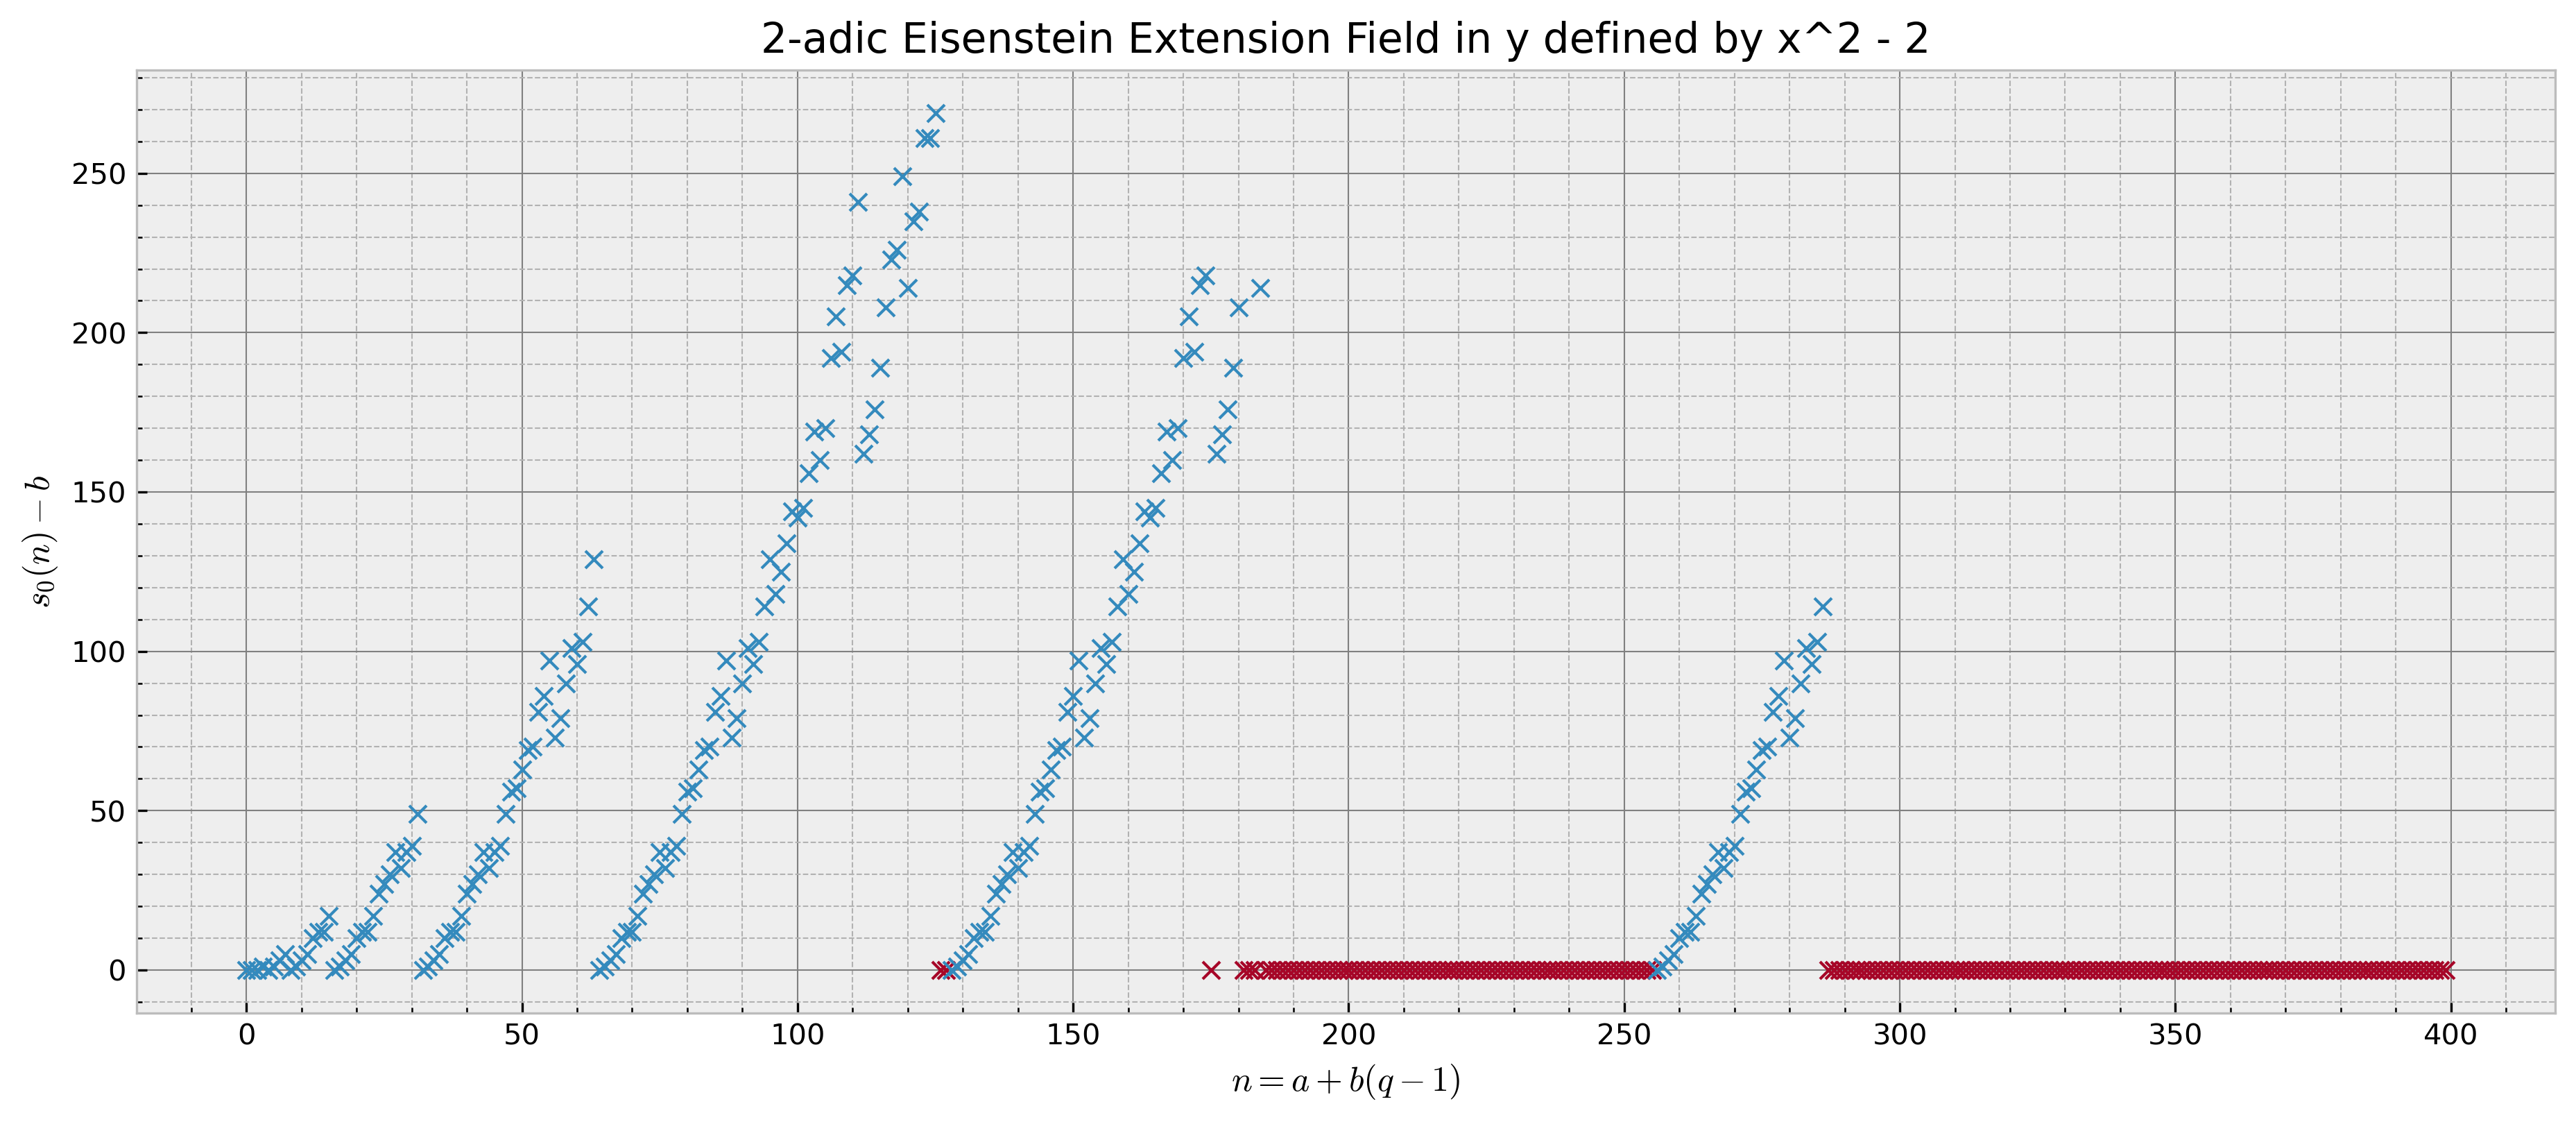

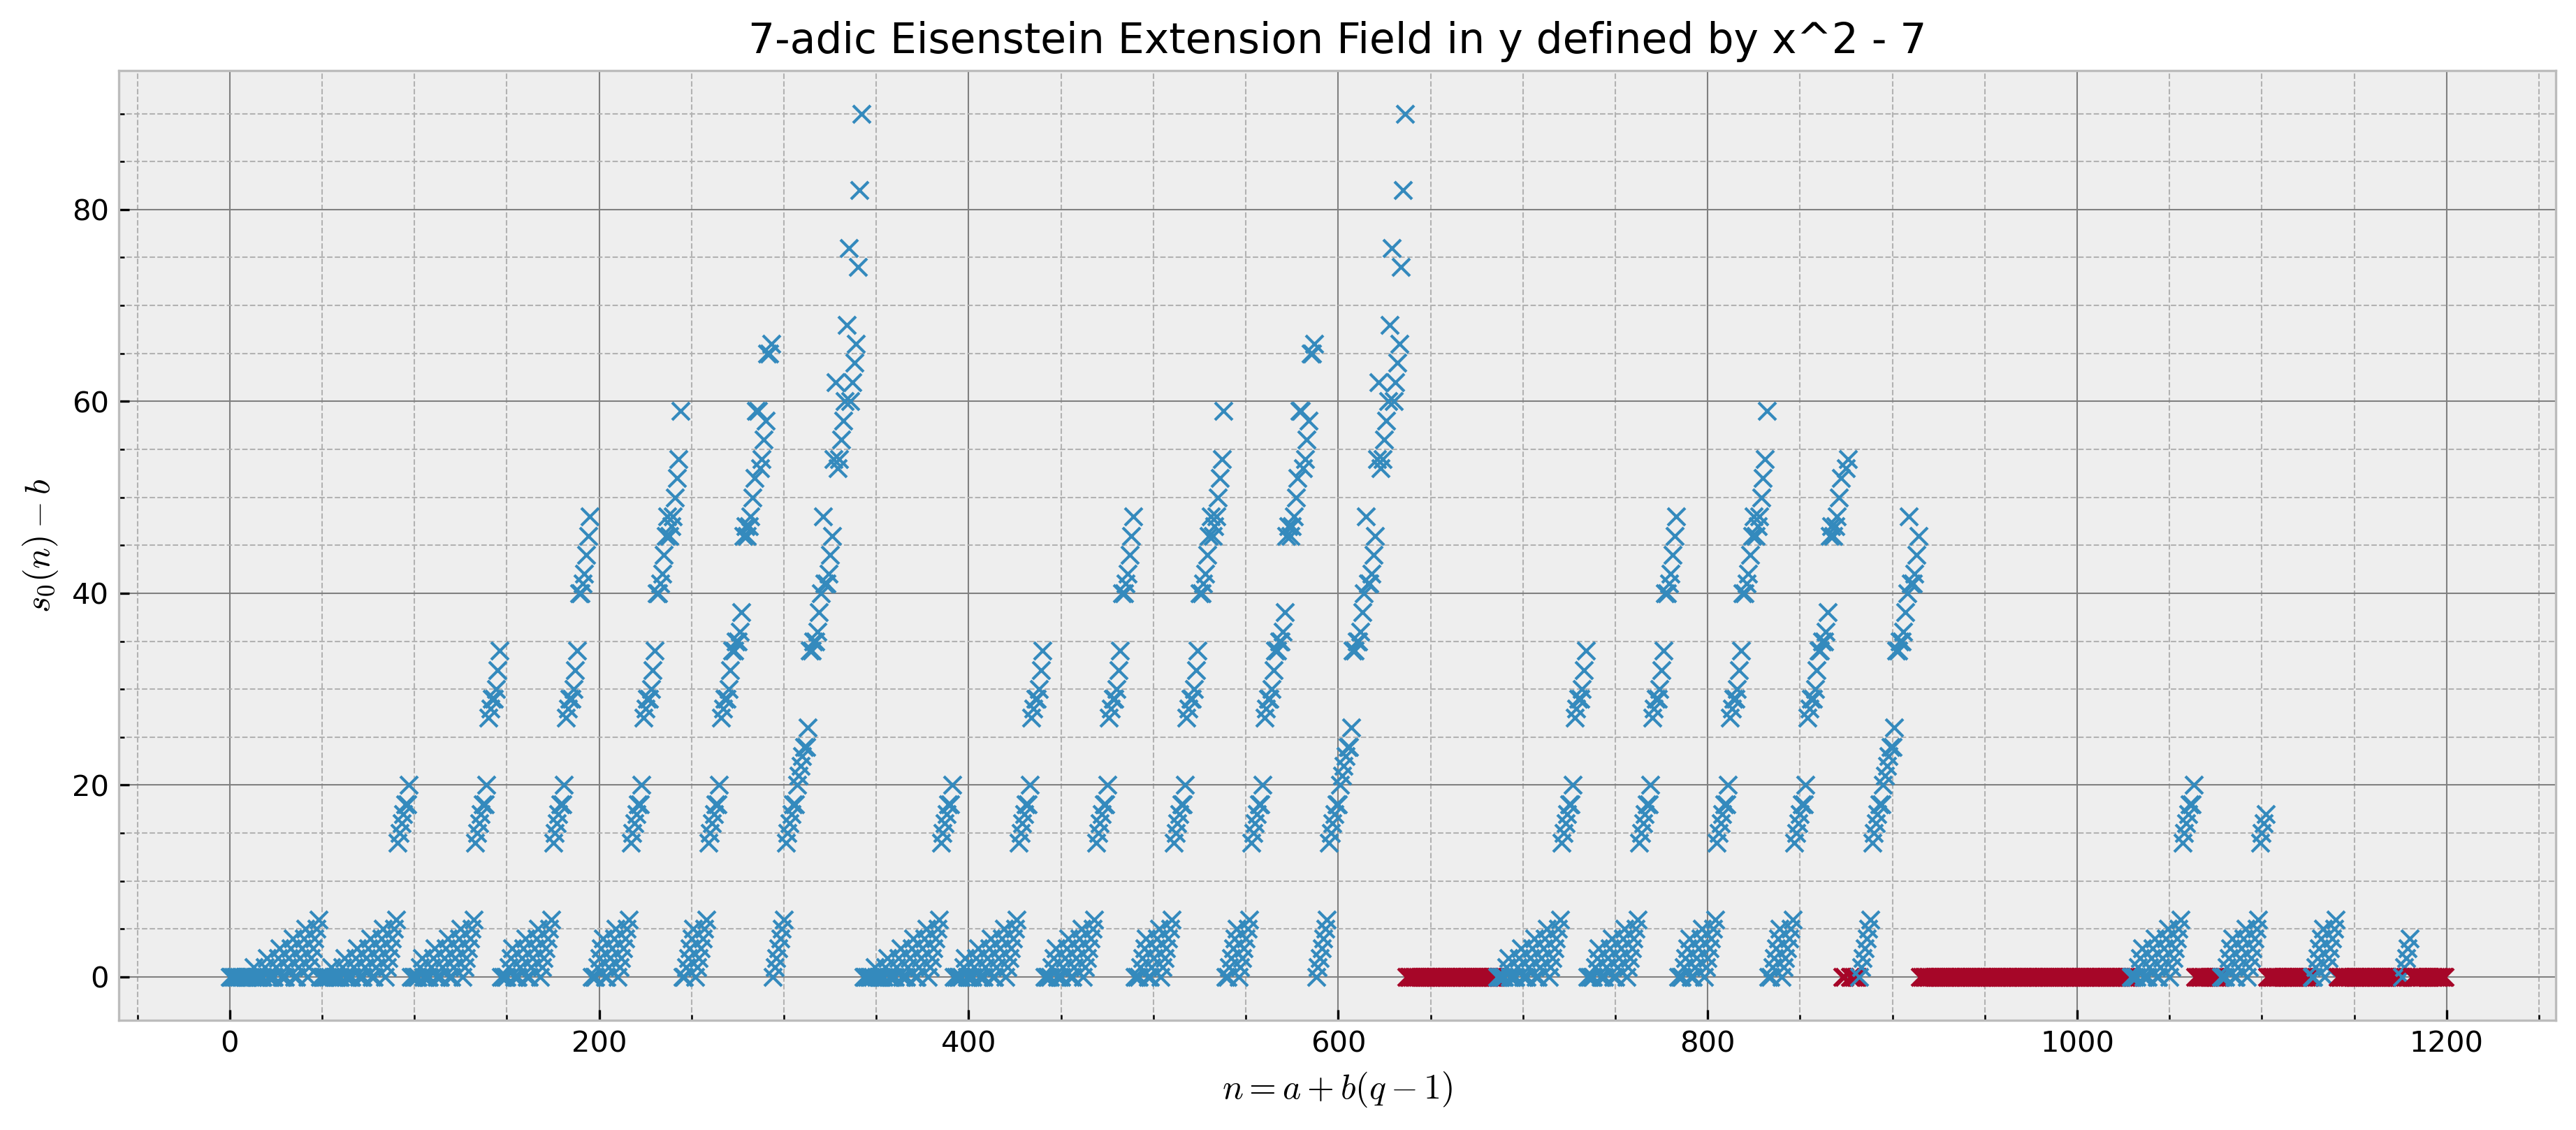

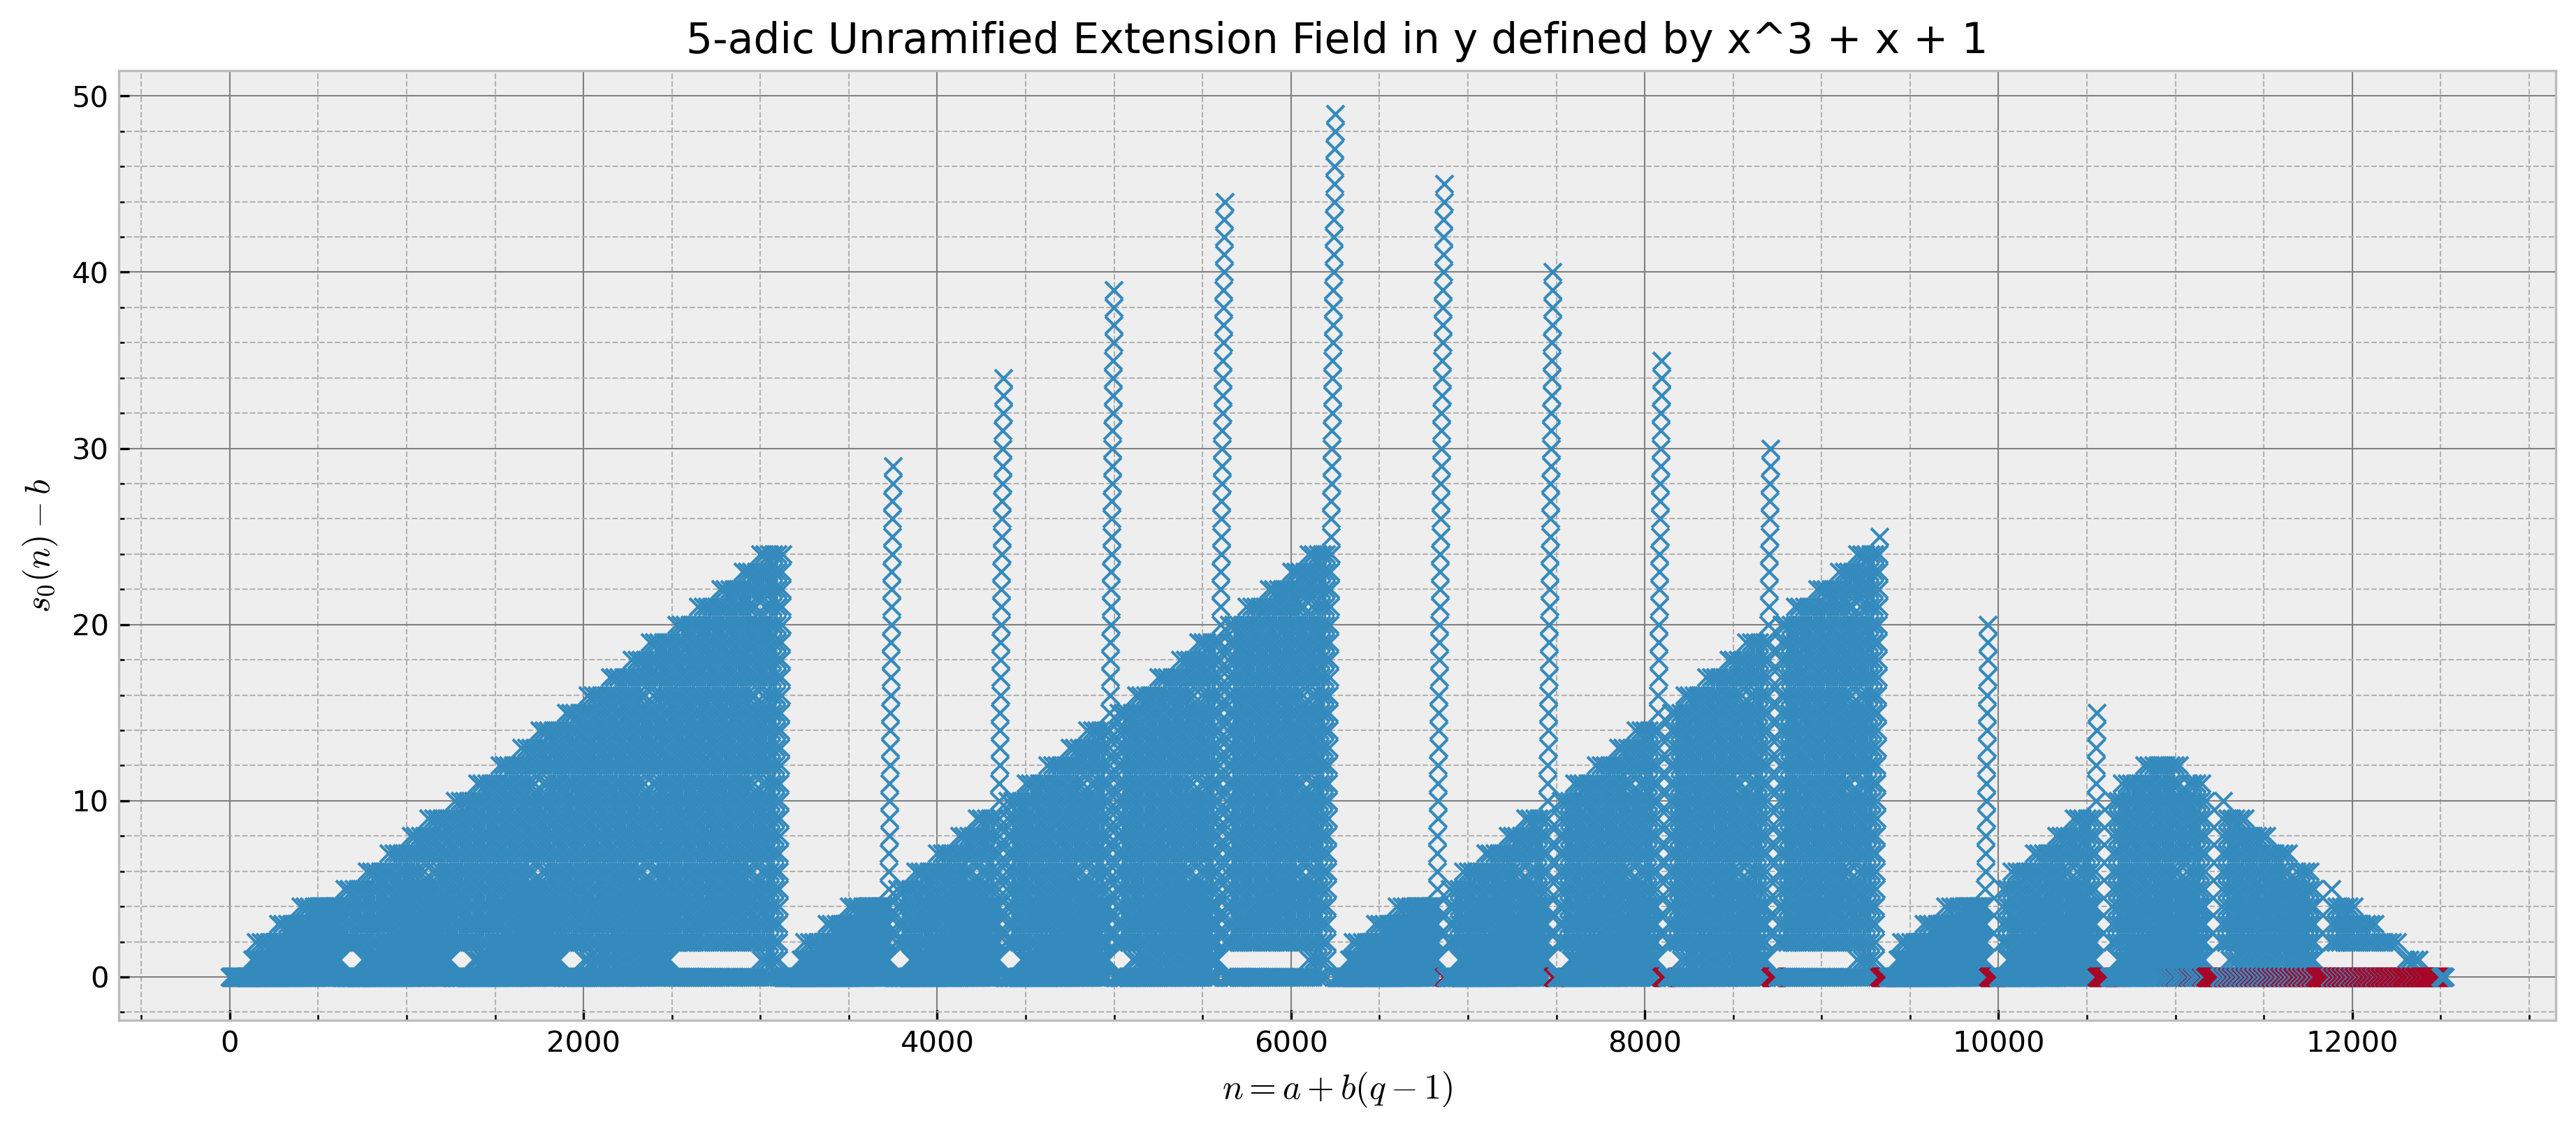

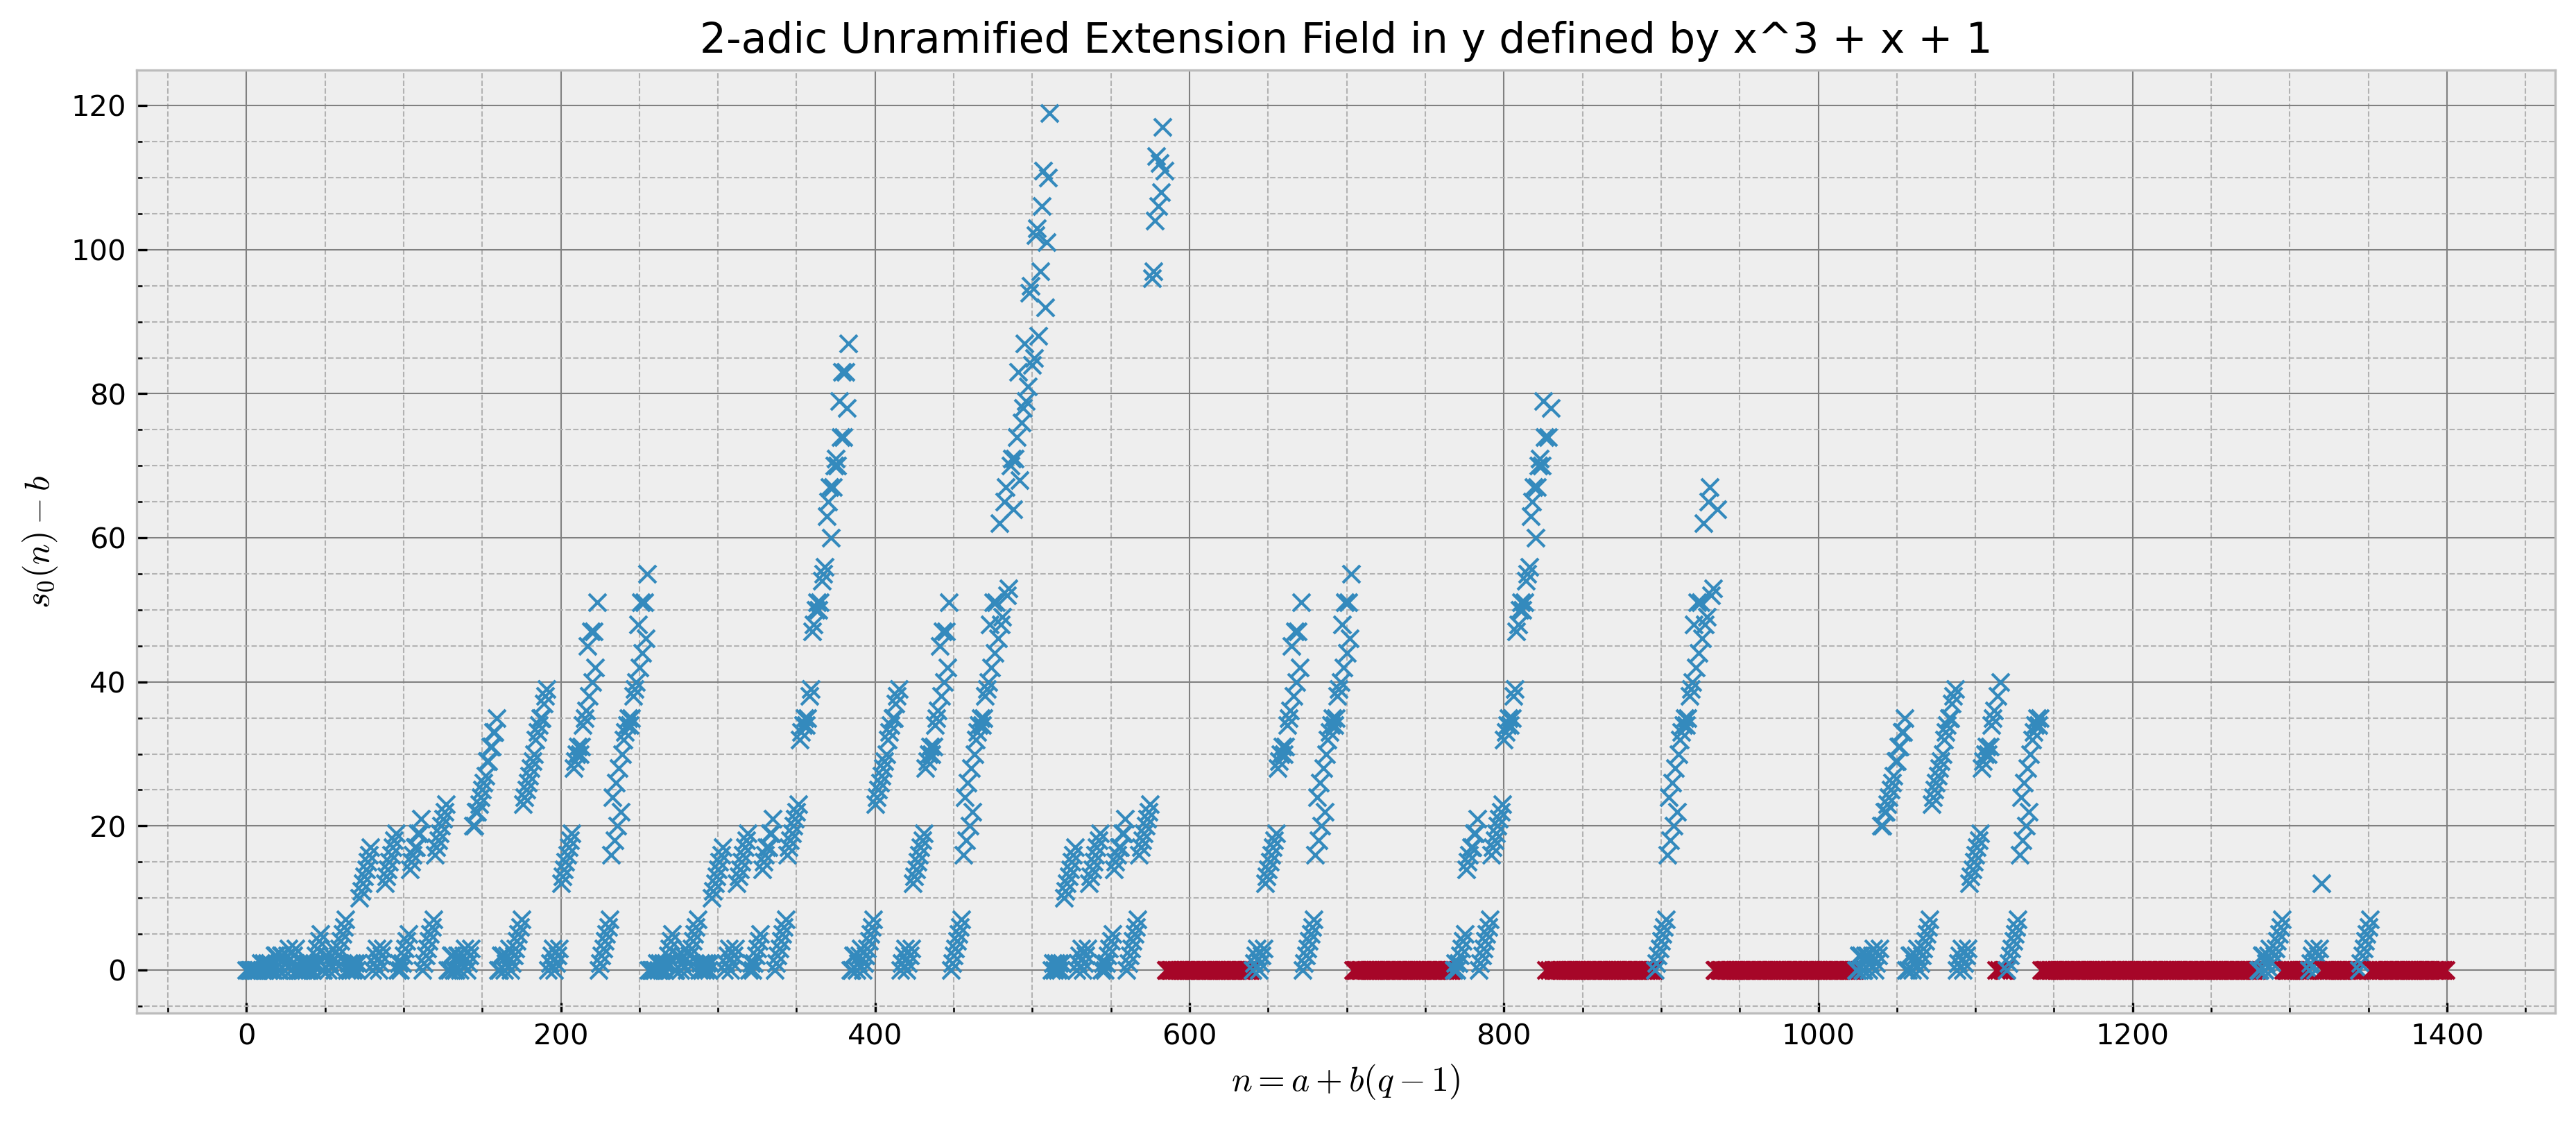

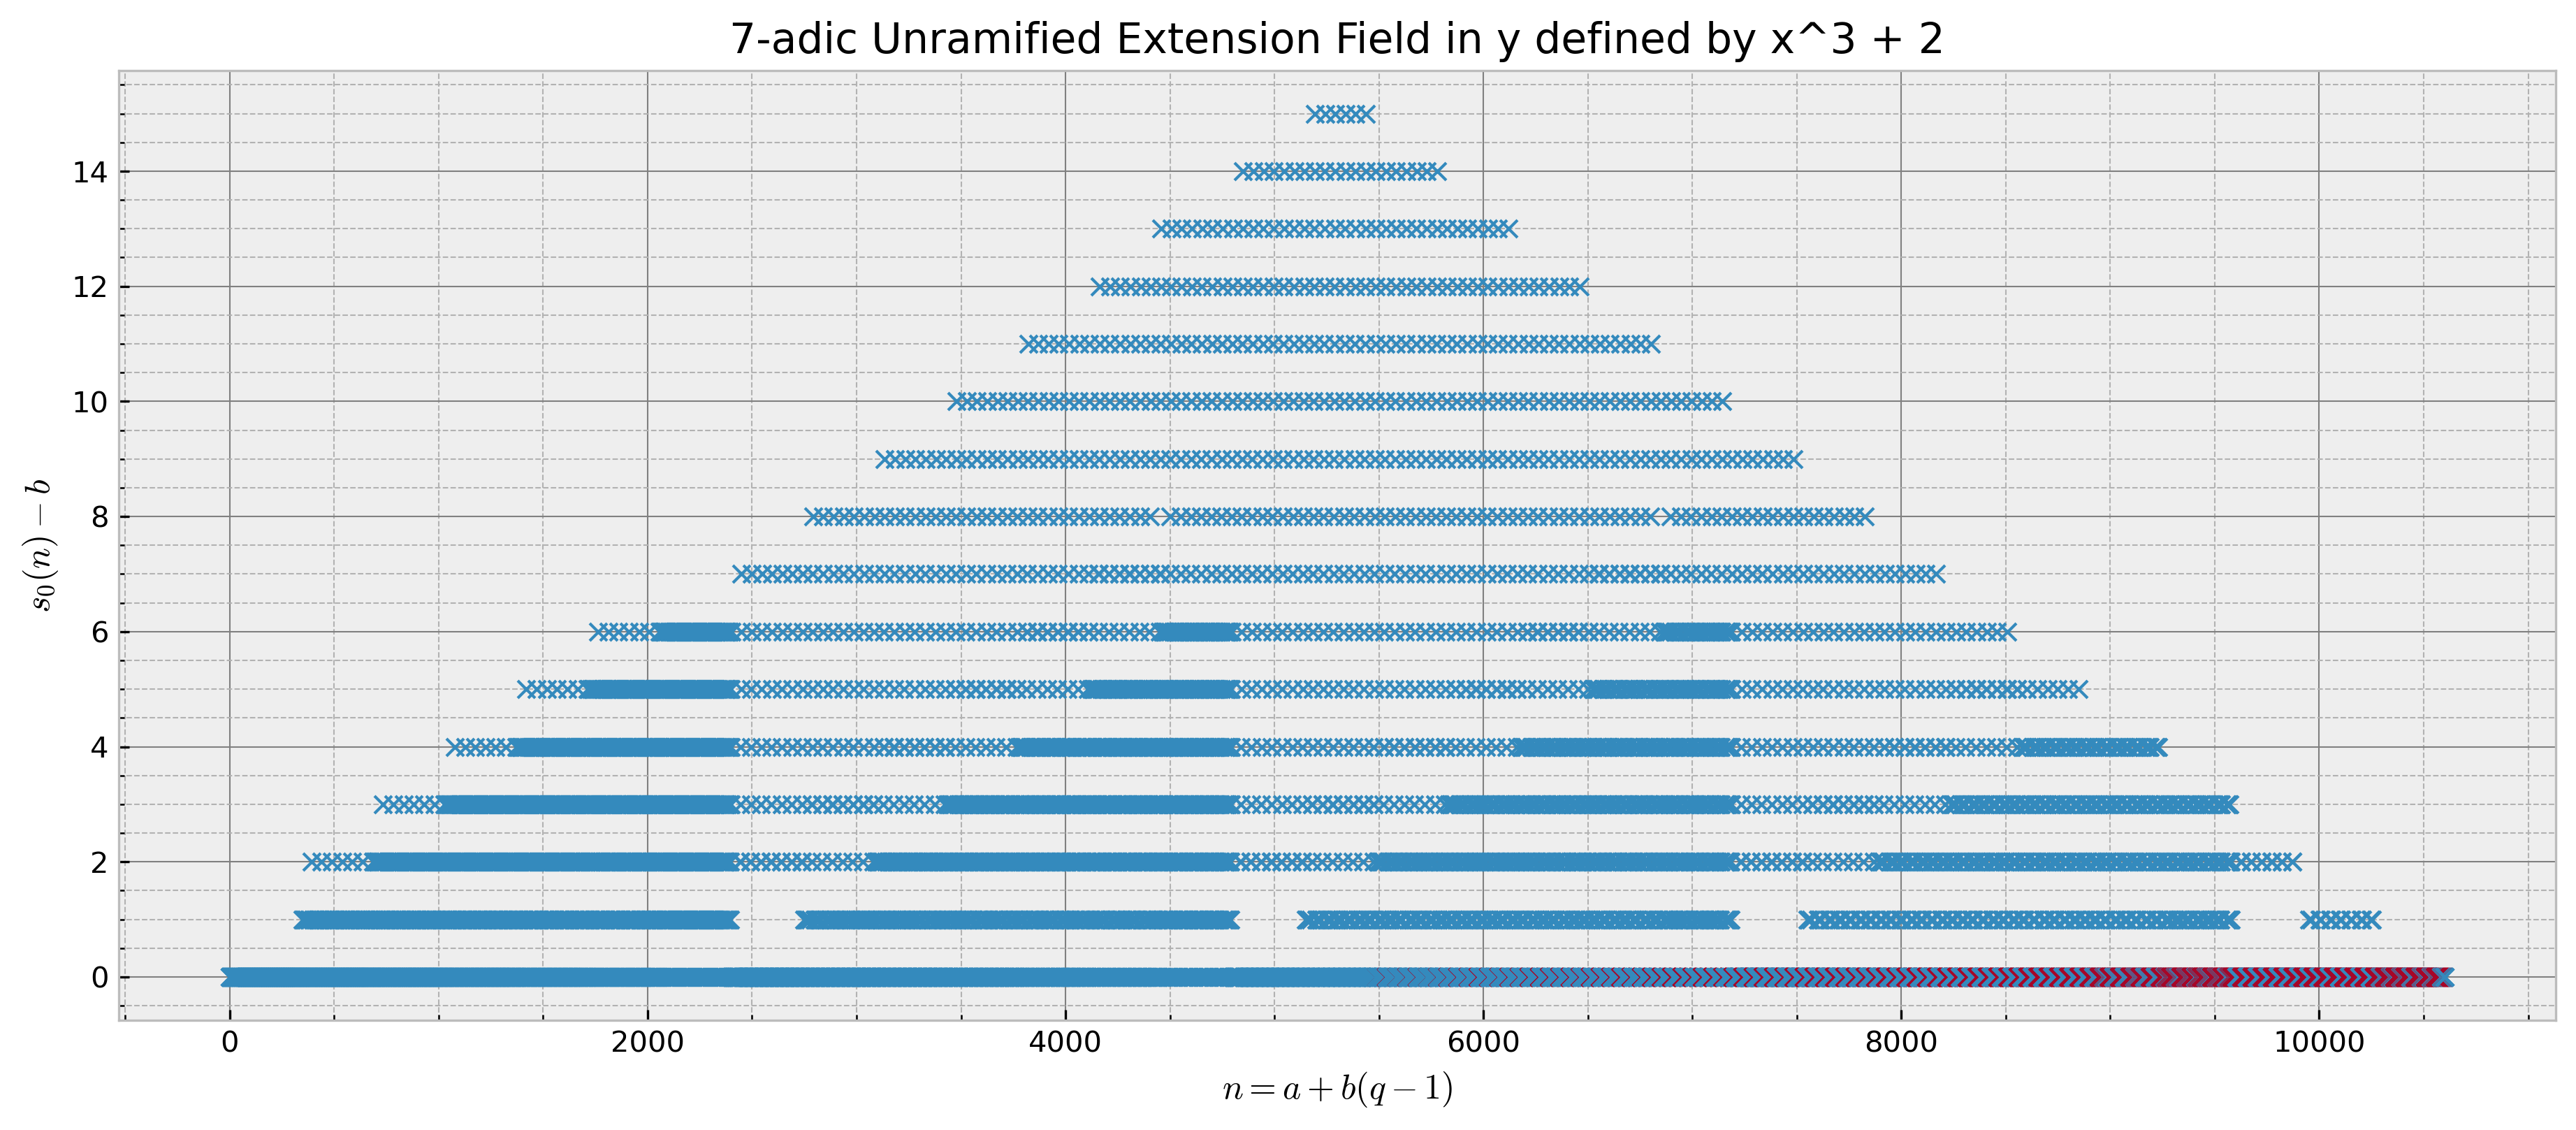

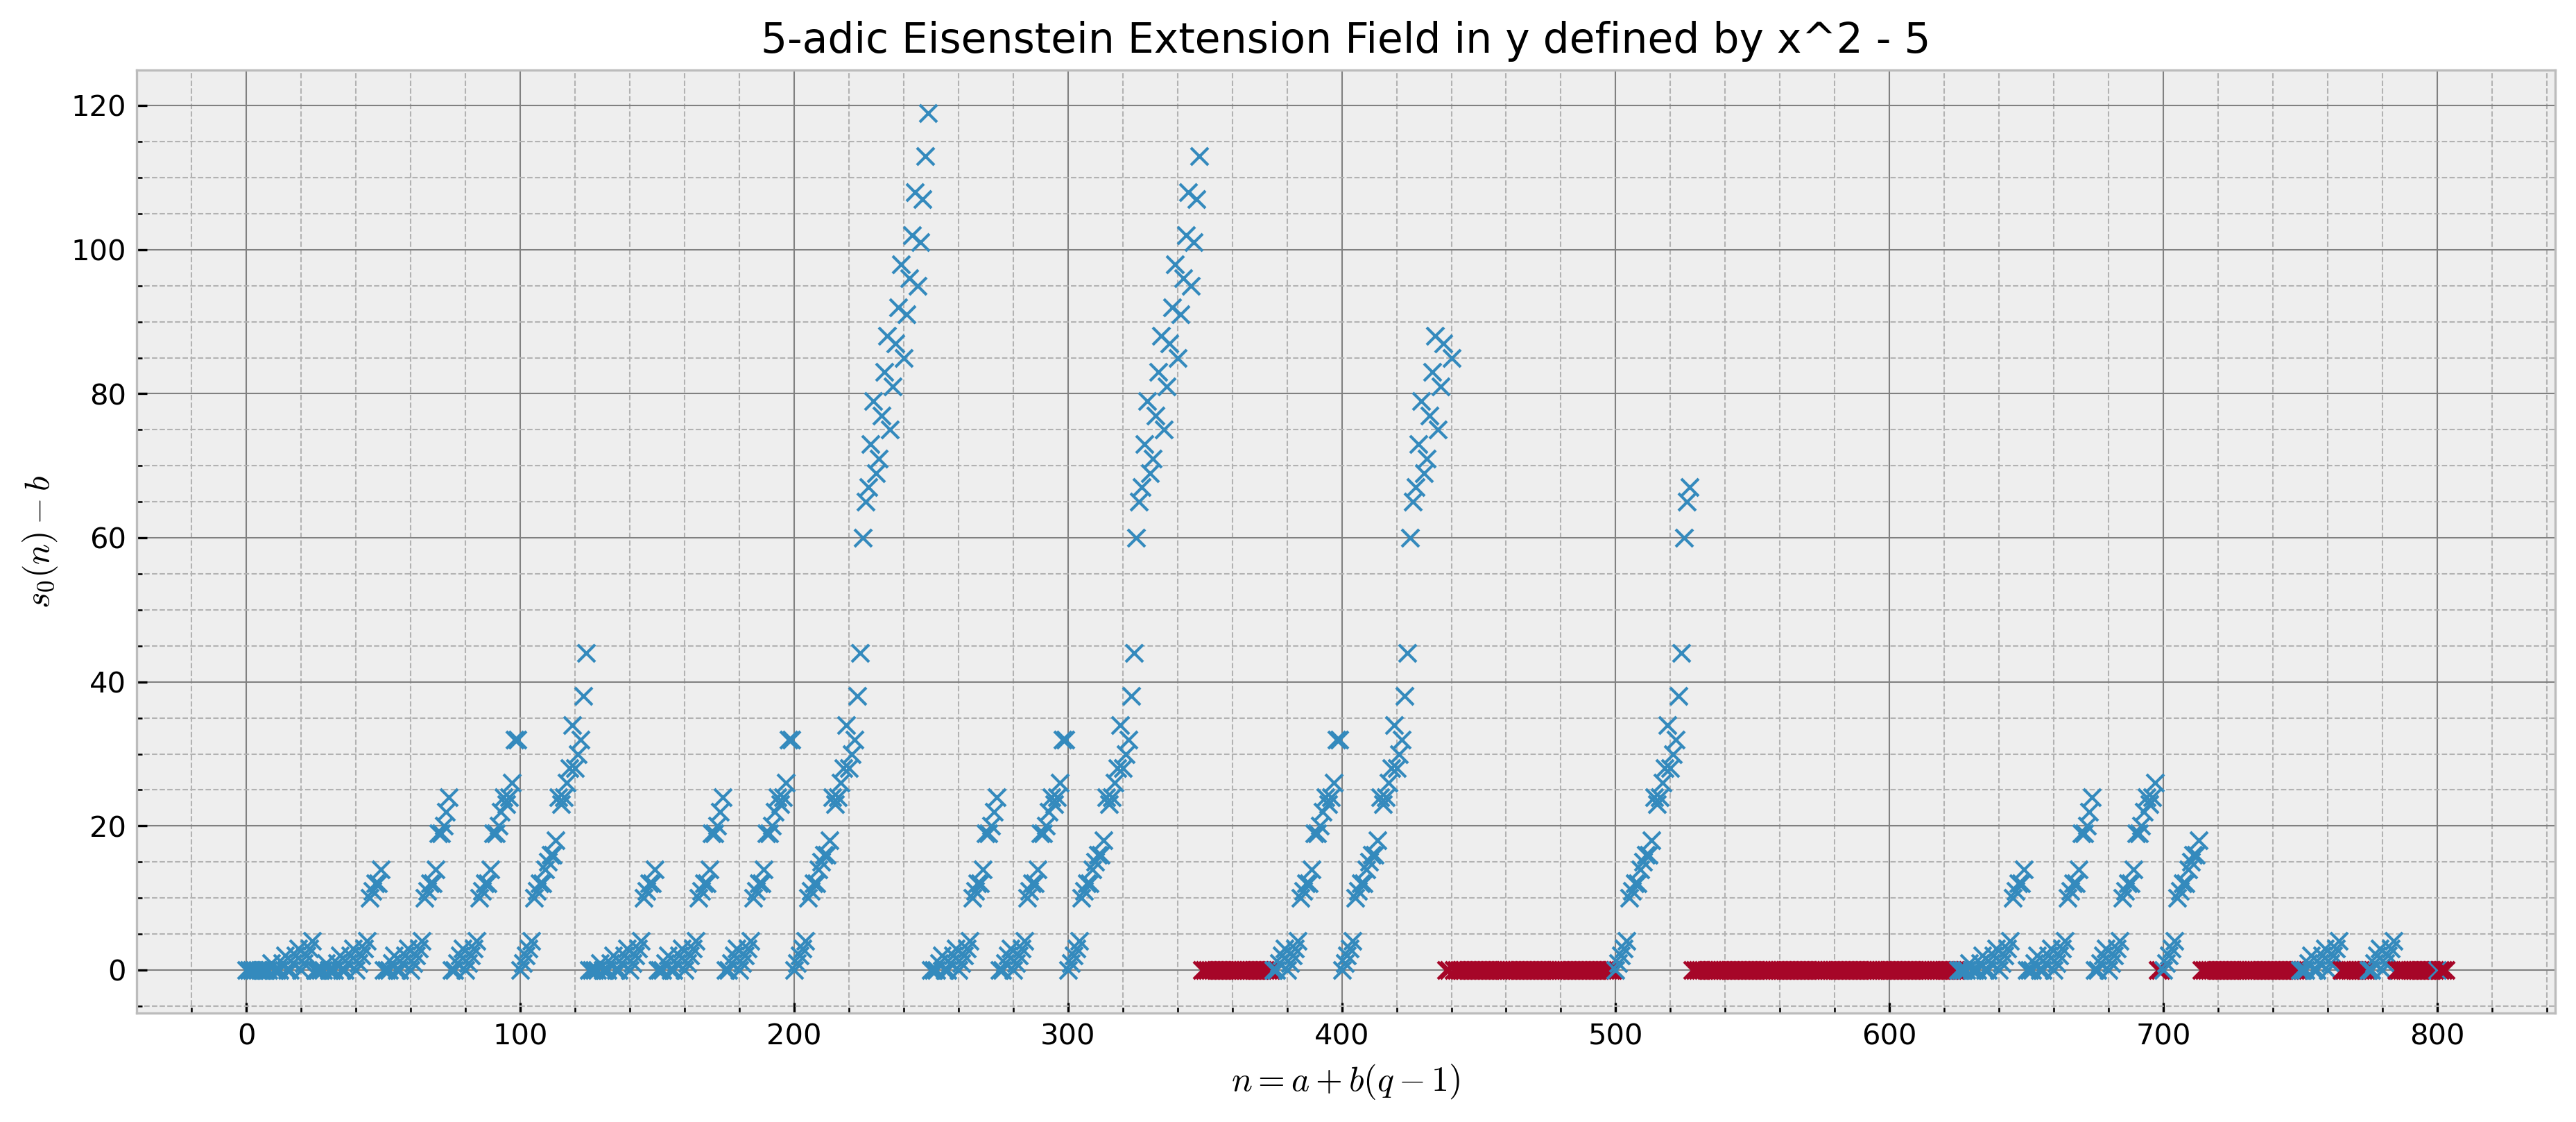

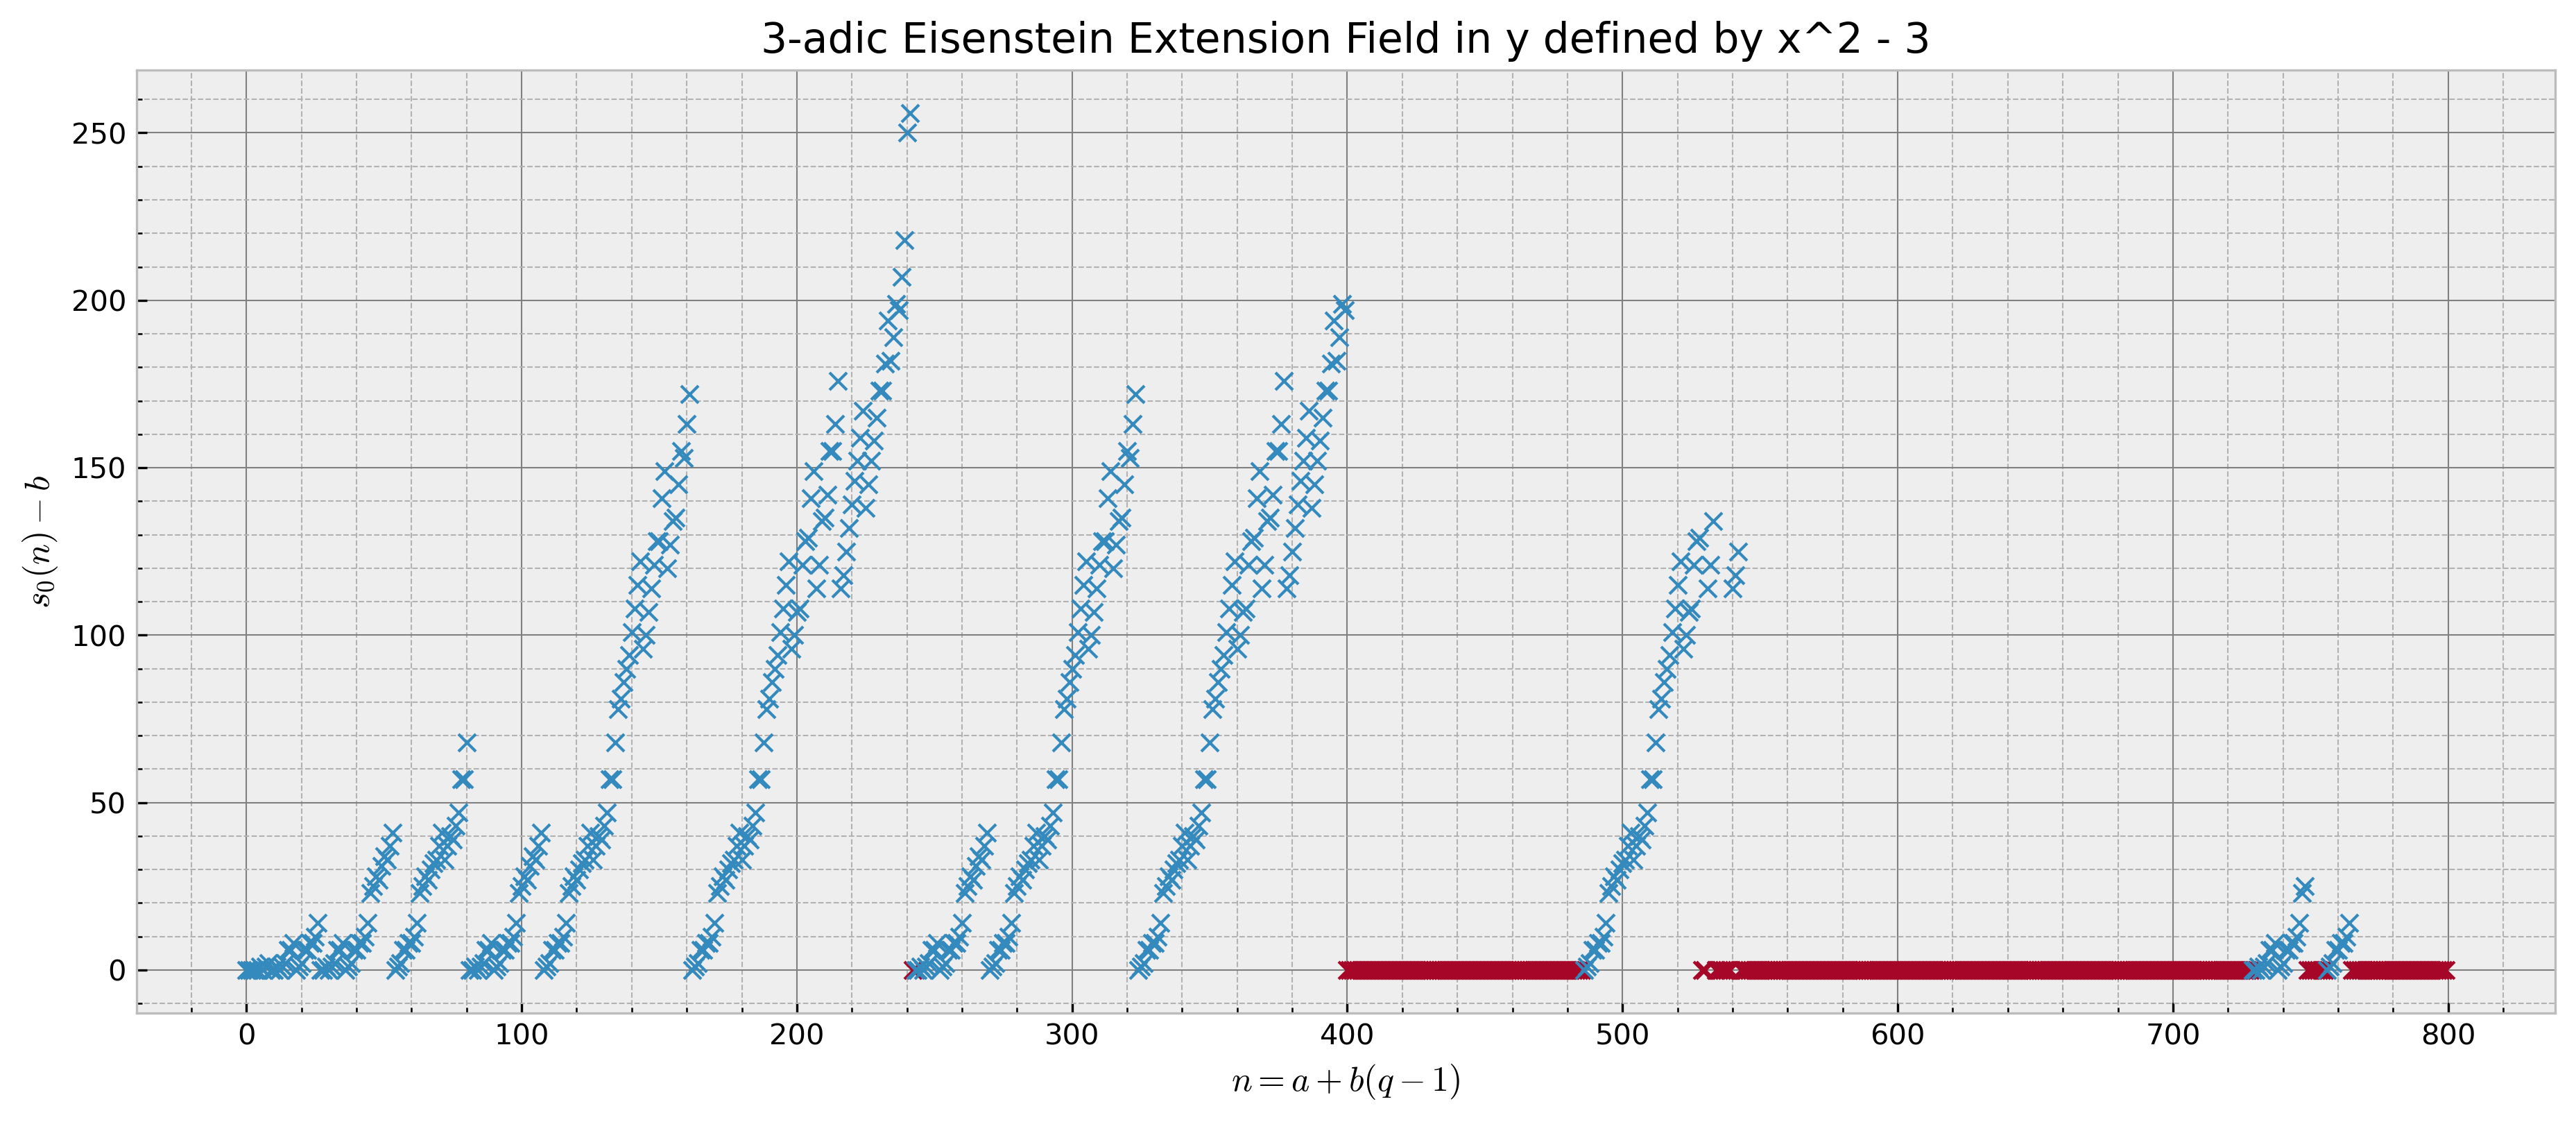

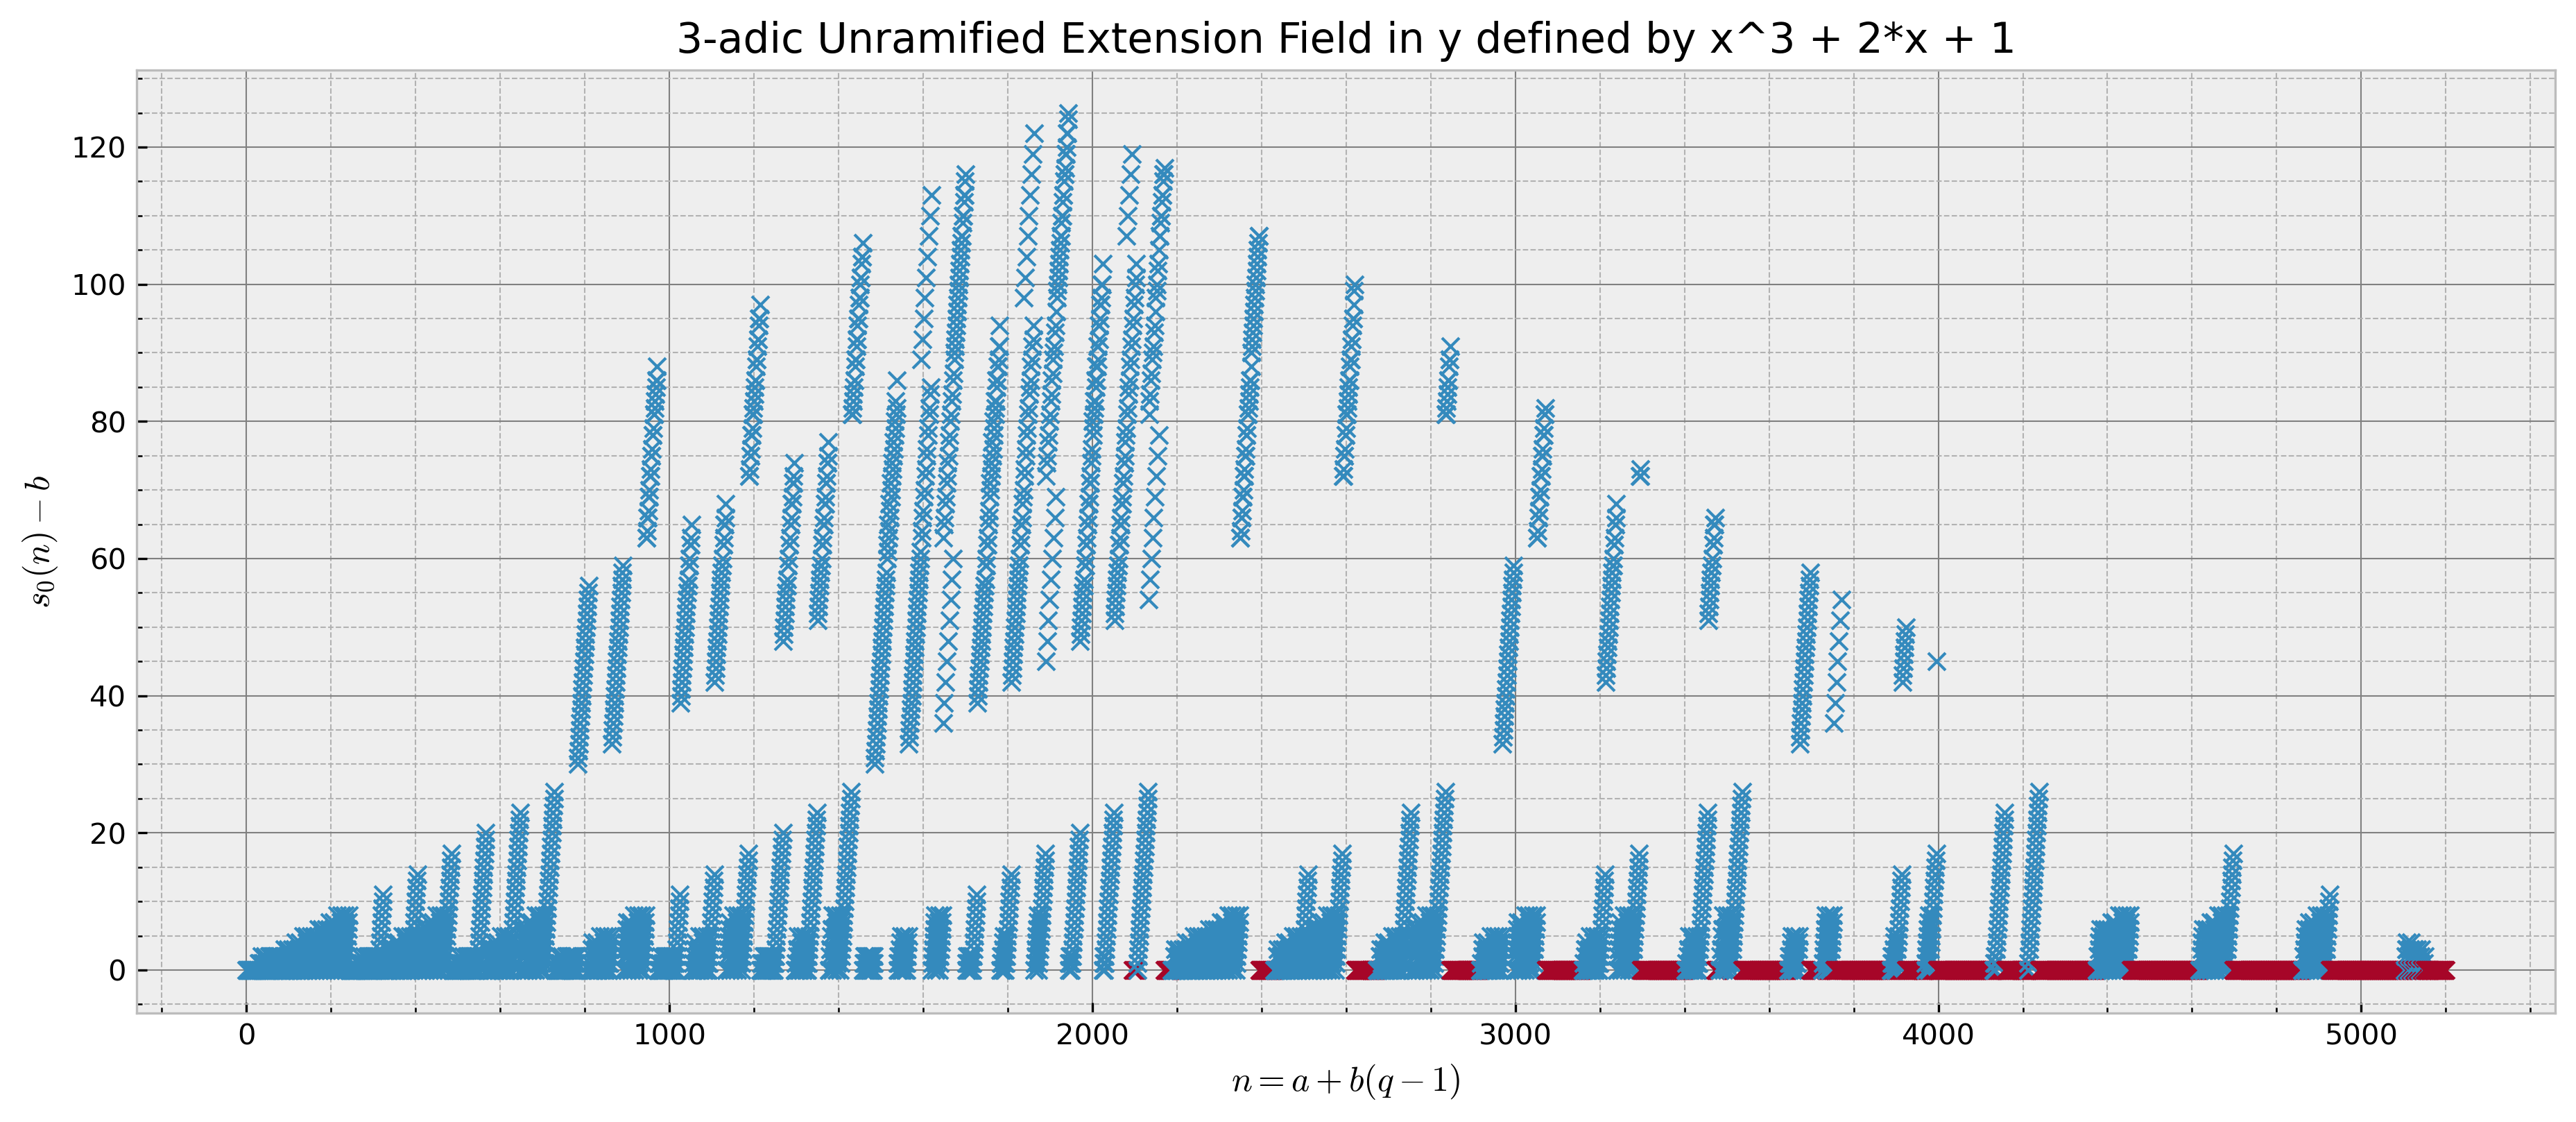

In [9]:
precision = 1000

for folder in glob.glob('./s0_data/**'):
    extension = folder.split('./s0_data/')[-1]

    parse = extension.split(',')
    p = int(parse[0])  # Prime to calculate with
    d = int(parse[1])  # Degree to calculate with
    N = int(parse[2])  # Cutoff; must be divisible by q-1
    ram = parse[3]


    # Python imports
    from time import process_time
    import matplotlib.pyplot as plt
    import numpy as np

    # Definitions
    from sage.rings.padics.padic_generic import ResidueLiftingMap
    from sage.rings.padics.padic_generic import ResidueReductionMap
    import sage.rings.padics.padic_extension_generic

    power = p^d - 1
    t_poly = ""

    if ram == "ram":
        t_poly = f"x^{d}-{p}"
    else:
        # generate poly for unramified case
        Fp = GF(p)
        Fp_t.<t> = PolynomialRing(Fp)
        unity_poly = t^(power) - 1
        factored = unity_poly.factor()
        factored_str = str(factored)
        start = factored_str.find("^"+str(d))
        last_brac_pos = factored_str.find(")",start)
        first_brac_pos = len(factored_str) \
                         - factored_str[::-1].find("(",len(factored_str)-start)
        t_poly = factored_str[first_brac_pos:last_brac_pos].replace('t','x')


    # Define the polynomial to adjoin a root from
    Q_p = Qp(p,precision)
    R_Qp.<x> = PolynomialRing(Q_p)
    f_poly = R_Qp(t_poly)

    # Define the p-adic field, its ring of integers and its residue field
    # These dummy objects are a workaround to force the precision wanted
    dummy1.<y> = Zp(p).ext(f_poly)
    dummy2.<y> = Qp(p).ext(f_poly)

    o_L.<y> = dummy1.change(prec=precision)
    L.<y> = dummy2.change(prec=precision)
    k_L = L.residue_field()
    print(L)

    # Find the generator of the unique maximal ideal in o_L. 
    Pi = o_L.uniformizer()

    # Find f, e and q
    f = k_L.degree()             # The degree of the residual field extension
    e = L.degree()/k_L.degree()  # The ramification index
    q = p^f

    # Do linear algebra over the ring of polynomials L[X]
    # in one variable X with coefficients in the field L:
    L_X.<X> = L[]
    L_Y.<Y> = L[]

    v = L.valuation()

    # The subroutine Dmatrix calculates the following sparse matrix of coefficients.
    # Let D[k,n] be equal to k! times the coefficient of Y^k in the polynomial P_n(Y). 
    # I compute this using the useful and easy recursion formula 
    #      D[k,n] = \sum_{r \geq 0} \pi^{-r} D[k-1,n-q^r] 
    # that can be derived from Laurent’s Prop 1.20 of "outline9".
    # The algorithm is as follows: first make a zero matrix with S rows and columns 
    # (roughly, S is (q-1)*Size), then quickly populate it one row at a time,
    # using the recursion formula.
    def Dmatrix(S):
        D = matrix(L, S,S)
        D[0,0] = 1
        for k in range(1,S):
            for n in range(k,S):
                r = 0
                while n >= q^r:
                    D[k,n] = D[k,n] + D[k-1,n-q^r]/Pi^r  # the actual recursion 
                    r = r+1
        return D


    # \Tau^{(m)} in Definition 10.10 of "bounded21":
    def TauMatrix(Size, m, D=None):
        if D is None:
            D = Dmatrix((q - 1) * (Size + 1))
        R = matrix(L, Size,Size, lambda x,y: D[m + (q-1)*x, m + (q-1)*y])

        # Define a diagonal matrix:
        Diag = matrix(L_X, Size,Size, lambda x,y: kronecker_delta(x,y) * X^x)

        # Compute the inverse of R:
        S = R.inverse()

        # Compute the matrix Tau using Lemma 10.11 in "bounded21":
        Tau = S * Diag * R

        return Tau

    def underscore(m, i):
        return m + i*(q-1)

    def w_q(n):
        return (n - sum(n.digits(base=q))) / (q-1)

    def compute_s(N, filename=None):
        assert N%(q-1) == 0
        
        s0 = []
        with open(f"{folder}/s0_data.txt") as f:
            for l in f.readlines()[1:]:
                s0.append( int(l.split(', ')[1]) )

        with open(f"{folder}/s0_data.txt", 'w') as f:
            f.write("n,s0\n")
            for n, s in enumerate(s0):
                f.write(f"{n},{s}\n")

        plt.style.use('bmh')
        fig = plt.figure(figsize=(15,6), dpi=300)
        for n, s in enumerate(s0):
            if s != -1:
                b = n // (q-1)
                plt.plot(n, s-b, 'x', c='C0')
            else:
                plt.plot(n, 0, 'x', c='C1')
        plt.xlabel(r"$n = a + b(q-1)$")
        plt.ylabel("$s_0(n) - b$")
        plt.title(str(L))
        plt.minorticks_on()
        plt.grid(which='both')
        plt.grid(which='major', linestyle='-', c='grey')
        plt.savefig(f"{folder}/s0_plot.png")

        return s0, fig


    s0 = compute_s(N);
